# Setup

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
from ortools.linear_solver import pywraplp
import time
import logging
import numpy as np

# Context

**Project Description**

WoodCraft Creations, a renowned woodcrafting company, is launching a new project to create
high-quality wooden tables for homes and offices. Their focus on sustainable sourcing and
timeless design ensures each table is both durable and stylish. The new table design requires the
following materials:
-  Wooden Planks:
    - `Tabletop`: 1 plank, providing a smooth, polished surface.
    - `Legs`: 4 planks, each supporting a leg.
    - `Beams`: 2 planks, connecting the legs for stability.
- Fasteners: `Screws` or nails to secure the legs, beams, and tabletop.
- Reinforcement: Metal `brackets` for added support at joints.
- Adhesive: Wood `glue` to reinforce joints and enhance stability.

WoodCraft Creations will develop production and ordering plans based on projected demand. This streamlined approach ensures efficient manufacturing and timely delivery of premium wooden tables.

In this project, WoodCraft Creations will use responsibly sourced materials, carefully selected to maintain environmental standards while delivering high-quality products. From cutting
and shaping wood planks to assembling and finishing the tables, the company ensures each step
of the production process meets its rigorous quality standards. With an experienced team and a
focus on bringing lasting value, this project aims to solidify WoodCraft Creations as a trusted
name in the furniture industry.
WoodCraft Creations has forecasted the demand for the new table over the next 16 days.
They anticipate introducing their tables within the next 5 days.

# PART I : Production Planning

## BOM
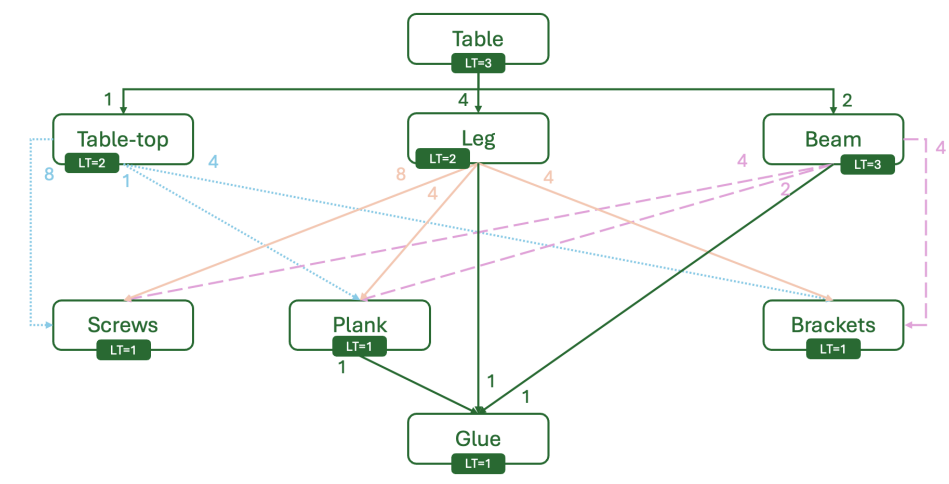

## Table 1: Demand of new Table in the upcoming 16 days
| Period   | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|----------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Demand   | 0  | 0  | 0  | 0  | 0  | 18 | 15 | 16 | 12 | 14 | 19 | 10 | 13 | 11 | 17 | 12 |

## Table 2: Information regarding production of the new table
| Product/material | Table | Tabletop | Leg | Beams | Screws | Planks | Brackets | Glue |
|------------------|-------|----------|-----|-------|--------|----------|--------|------|
| Lead-time        | 3     | 2        | 2   | 3     | 1      | 1        | 1      | 1    |
| Initial inventory| 0     | 20       | 100 | 70    | 50     | 100      | 50     | 100  |
| Production cost  | 100   | 100      | 100 | 100   | 100    | 100      | 100    | 100  |
| Inventory cost   | 20    | 10       | 10  | 10    | 5      | 5        | 5      | 5    |
| Setup cost       | 500   | 200      | 200 | 200   | 200    | 200      | 200    | 200  |


## Question 1

1. Determine the production and ordering plans for the table and its sub-materials. Solve
the optimal integrated model and also utilize the decomposition approach. Describe the
results, highlighting the differences.

From now on, continue with the optimal method and **retain the input of each question for
the subsequent ones.**

### Setting up data and the optimization function

In [38]:
def opt_production_plan(data):
  logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
  # Create the mip solver with the SCIP backend.
  m = pywraplp.Solver.CreateSolver('SCIP')
  logging.debug("Solver created.")
  # decision variables
  obj = m.NumVar(0, 1000000000, 'obj')

  setup = []
  production = []
  inventory = []
  for product in range(len(data.demands)):
    setup_temp = []
    production_temp = []
    inventory_temp = []
    for day in range(len(data.days)):
        suffix = '_{}_{}'.format(product, day)
        setup_temp.append(m.BoolVar('setup' + suffix))
        production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
        inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

    setup.append(setup_temp)
    production.append(production_temp)
    inventory.append(inventory_temp)
  logging.debug("Variables created.")


  # constraints
  m.Add(obj >= sum(
      sum(production[product]) * data.production_cost[product] +
      sum(setup[product]) * data.setup_cost[product] + 
      sum(inventory[product][:-1] * data.inventory_cost[product])
        for product in range(len(data.demands))))
  logging.debug("Objective function added.")
  # Demand constraint
  for product in range(len(data.demands)):
    for day in data.days:
      # Setup constraint
      #logging.debug(f"Adding setup constraint for product {product}, day {day}.")
      m.Add(production[product][day] <= 100000 * setup[product][day])
      #logging.debug(f"Setup constraint for product {product}, day {day} added.")

      if day != 0:
        if day - data.lead_time[product] >= 0:
            m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                  (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
      else:
        m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])
      #logging.debug(f"Demand balance constraint for product {product}, day {day} added.")

  logging.debug("All constraints added.")

  # objective function
  m.Minimize(obj)
  logging.debug("Objective function set to minimize.")
  # solving the model
  status = m.Solve()
  logging.debug(f"Solving the model, solver status: {status}")
  if status == pywraplp.Solver.OPTIMAL:

      PRODUCTION_PLAN = {}
      for product in range(len(data.demands)):
        PRODUCTION_PLAN_temp = {}
        for m_idx, day in enumerate(data.days):
            PRODUCTION_PLAN_temp[day] = {
                'product ' + str(product):   production[product][m_idx].solution_value(), \
                'setup':                     setup[product][m_idx].solution_value(), \
                'inventory':                 inventory[product][m_idx].solution_value()
                }
        PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
      logging.debug("Optimal solution found.")
      return PRODUCTION_PLAN, obj.solution_value()

  elif status == pywraplp.Solver.FEASIBLE:
      logging.debug("Solver found a feasible solution, not necessarily optimal.")
  elif status == pywraplp.Solver.INFEASIBLE:
      logging.debug("Solver found the problem to be infeasible.")
  elif status == pywraplp.Solver.UNBOUNDED:
      logging.debug("Solver found the problem to be unbounded.")
  else:
      logging.debug("Solver ended with an unknown status.")

In [39]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand (calculated)
            [0]*16,  # Leg demand (calculated)
            [0]*16,  # Beam demand (calculated)
            [0]*16,  # Screw demand (calculated)
            [0]*16,  # Plank demand (calculated)
            [0]*16,  # Bracket demand (calculated)
            [0]*16   # Glue demand (calculated)
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

### Using integrated model to find Optimum

In [40]:
start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
'''for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
  print('objective is : 'xxx)'''
values = [22300, 14760, 54200, 25940, 625600, 265170, 359725, 332100]

for product in range(len(data.demands)):
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
    print(f'partial objective is : {values[product]}')
print('final objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:07:42,071 - DEBUG - Solver created.
2024-06-14 01:07:42,075 - DEBUG - Variables created.
2024-06-14 01:07:42,088 - DEBUG - Objective function added.
2024-06-14 01:07:42,105 - DEBUG - All constraints added.
2024-06-14 01:07:42,112 - DEBUG - Objective function set to minimize.
2024-06-14 01:07:49,945 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:07:49,945 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,-0.0,0.0,13.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,-0.0,40.0,29.0,12.0,0.0


partial objective is : 22300


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


partial objective is : 14760


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,220.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


partial objective is : 54200


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,110.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


partial objective is : 25940


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1073.0,2200.0,0.0,0.0,424.0,2120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


partial objective is : 625600


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,489.0,935.0,0.0,0.0,212.0,901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


partial objective is : 265170


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,756.0,1100.0,0.0,0.0,424.0,1060.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


partial objective is : 359725


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,550.0,1108.0,220.0,0.0,212.0,1007.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


partial objective is : 332100
final objective is :  1699796 . Run time is :  7.896997690200806


### Using Decomposition approach to observe
#### MPS

In [41]:
class data_generator_MPS():

  def __init__(self):

    self.demands = [[0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [3]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0]
    self.inventory_cost = [20] * len(self.demands)
    self.setup_cost = [500] * len(self.demands)

start_time = time.time()
data = data_generator_MPS()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:05,240 - DEBUG - Solver created.
2024-06-14 01:08:05,240 - DEBUG - Variables created.
2024-06-14 01:08:05,240 - DEBUG - Objective function added.
2024-06-14 01:08:05,245 - DEBUG - All constraints added.
2024-06-14 01:08:05,246 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:05,262 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:05,264 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,0.0,33.0,0.0,28.0,0.0,14.0,29.0,0.0,24.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,0.0,10.0,0.0,11.0,0.0,12.0,0.0


objective is :  19900 . Run time is :  0.0328974723815918


#### MRP
##### table top

In [42]:
class data_generator_MRP_tabelT():

  def __init__(self):

    self.demands = [[0, 0, 33, 0, 28, 0, 14, 29, 0, 24, 0, 29, 0, 0, 0, 0]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    
    self.lead_time = [2]

    self.first_inventory = [20]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_tabelT()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

print('Table top obj fct: ')
run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:08,417 - DEBUG - Solver created.
2024-06-14 01:08:08,418 - DEBUG - Variables created.
2024-06-14 01:08:08,421 - DEBUG - Objective function added.
2024-06-14 01:08:08,422 - DEBUG - All constraints added.
2024-06-14 01:08:08,422 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:08,422 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:08,429 - DEBUG - Optimal solution found.


Table top obj fct: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,13.0,0.0,28.0,0.0,14.0,29.0,0.0,24.0,-0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


objective is :  15300 . Run time is :  0.017823219299316406


##### Leg

In [43]:
class data_generator_MRP_leg():

  def __init__(self):

    self.demands = [[0.0, 0.0, 132.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0]
]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    
    self.lead_time = [2]



    self.first_inventory = [100]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_leg()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:11,320 - DEBUG - Solver created.
2024-06-14 01:08:11,321 - DEBUG - Variables created.
2024-06-14 01:08:11,322 - DEBUG - Objective function added.
2024-06-14 01:08:11,323 - DEBUG - All constraints added.
2024-06-14 01:08:11,324 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:11,324 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:11,328 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,32.0,0.0,112.0,0.0,56.0,116.0,0.0,96.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  56000 . Run time is :  0.01572895050048828


##### Beams

In [44]:
class data_generator_MRP_beam():

  def __init__(self):

    self.demands = [[0.0, 0.0, 66.0, 0.0, 56.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [3]

    self.first_inventory = [70]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_beam()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:13,721 - DEBUG - Solver created.
2024-06-14 01:08:13,721 - DEBUG - Variables created.
2024-06-14 01:08:13,729 - DEBUG - Objective function added.
2024-06-14 01:08:13,730 - DEBUG - All constraints added.
2024-06-14 01:08:13,731 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:13,733 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:13,734 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,52.0,0.0,28.0,58.0,0.0,48.0,-0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,70.0,70.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


objective is :  26880 . Run time is :  0.01629495620727539


##### Screws

In [45]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 8 for num in list1]
list2_multiplied = [num * 8 for num in list2]
list3_multiplied = [num * 4 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for screws will be : {combined_list}')

The demand for screws will be : [360.0, 208.0, 1120.0, 112.0, 792.0, 1160.0, 192.0, 960.0, 232.0, 1160.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [46]:
class data_generator_MRP_screws():

  def __init__(self):

    self.demands = [[360, 208, 1120, 112, 792, 1160, 192, 960, 232, 1160, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_screws()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:18,124 - DEBUG - Solver created.
2024-06-14 01:08:18,124 - DEBUG - Variables created.
2024-06-14 01:08:18,130 - DEBUG - Objective function added.
2024-06-14 01:08:18,134 - DEBUG - All constraints added.
2024-06-14 01:08:18,136 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:18,140 - DEBUG - Solving the model, solver status: 2
2024-06-14 01:08:18,142 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">We observe that **The problem does not have an optimal solution.** Because screws will need to start at -1 in order to be ready for the production at day 1.</span>

##### Plank

In [ ]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 1 for num in list1]
list2_multiplied = [num * 4 for num in list2]
list3_multiplied = [num * 2 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for planks will be : {combined_list}')

The demand for planks will be : [141.0, 104.0, 476.0, 56.0, 354.0, 493.0, 96.0, 408.0, 116.0, 493.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [47]:
class data_generator_MRP_planks():

  def __init__(self):

    self.demands = [[141, 104, 476, 56, 354, 493, 96, 408, 116, 493, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [100]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:22,746 - DEBUG - Solver created.
2024-06-14 01:08:22,749 - DEBUG - Variables created.
2024-06-14 01:08:22,751 - DEBUG - Objective function added.
2024-06-14 01:08:22,756 - DEBUG - All constraints added.
2024-06-14 01:08:22,757 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:22,759 - DEBUG - Solving the model, solver status: 2
2024-06-14 01:08:22,761 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">We observe the same, as to satisfy the demand for `table-top`, `beam` and `leg` the production for plank should also start at -1 day like for `screws`</span>

##### Brackets

In [48]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 4 for num in list1]
list2_multiplied = [num * 4 for num in list2]
list3_multiplied = [num * 4 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for brackets will be : {combined_list}')

The demand for brackets will be : [180.0, 208.0, 560.0, 112.0, 512.0, 580.0, 192.0, 480.0, 232.0, 580.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [49]:
class data_generator_MRP_brackets():

  def __init__(self):

    self.demands = [[180, 208, 560, 112, 512, 580, 192, 480, 232, 580, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:28,260 - DEBUG - Solver created.
2024-06-14 01:08:28,261 - DEBUG - Variables created.
2024-06-14 01:08:28,262 - DEBUG - Objective function added.
2024-06-14 01:08:28,265 - DEBUG - All constraints added.
2024-06-14 01:08:28,265 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:28,265 - DEBUG - Solving the model, solver status: 2
2024-06-14 01:08:28,265 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">same problem</span>

##### Glue

In [50]:
# demand for glue for each leg, plank and beams
list1 = [141.0, 104.0, 476.0, 56.0, 354.0, 493.0, 96.0, 408.0, 116.0, 493.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 1 for num in list1]
list2_multiplied = [num * 1 for num in list2]
list3_multiplied = [num * 1 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
print(f'The demand for glue will be : {combined_list}')

The demand for glue will be : [173.0, 156.0, 588.0, 84.0, 468.0, 609.0, 144.0, 504.0, 174.0, 609.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [51]:
class data_generator_MRP_planks():

  def __init__(self):

    self.demands = [[173.0, 156.0, 588.0, 84.0, 468.0, 609.0, 144.0, 504.0, 174.0, 609.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [100]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:33,028 - DEBUG - Solver created.
2024-06-14 01:08:33,029 - DEBUG - Variables created.
2024-06-14 01:08:33,030 - DEBUG - Objective function added.
2024-06-14 01:08:33,032 - DEBUG - All constraints added.
2024-06-14 01:08:33,033 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:33,035 - DEBUG - Solving the model, solver status: 2
2024-06-14 01:08:33,035 - DEBUG - Solver found the problem to be infeasible.


TypeError: cannot unpack non-iterable NoneType object

<span style="color: orange">
same problem, one solution could be to have more intial inventory in order to satisfy the demand for our product.

The integrated model and the decomposition approach to production planning handle the synchronization of production processes differently, which leads to discrepancies in their results, particularly regarding feasibility and efficiency.

**Integrated Model Approach:**
In the integrated model, the entire production process—right from raw materials to final product assembly—is considered as a single cohesive system. This model effectively coordinates all the sub-processes, ensuring that the timing of raw material acquisition, component production, and final assembly is synchronized across all stages. The solver used in the integrated model calculates the optimal production start times for each component, ensuring that all parts are available precisely when needed for assembly, despite the lead times. This is why the integrated model output seems feasible and presents a coherent production plan.

**Decomposition Approach:**
On the other hand, the decomposition approach breaks down the overall production process into smaller, independent units, each optimized separately. While this approach can simplify calculations and potentially increase focus on specific areas or units, it leads to a significant challenge: it does not inherently account for the interdependencies between different production stages. For instance, when you optimize sub-components like screws or planks separately, the model does not account for their necessary synchronization with the production of other parts like table tops or legs. As such, the decomposition model shows that production needs to start before day 1 to meet the demand by the given lead times, a situation that's obviously not feasible.

In essence, the decomposition approach highlights a critical flaw when it comes to the timing of each sub-component's production, suggesting the initiation of production activities before actual start capability (before day 1). This points out a non-feasible solution under actual production constraints and underscores the importance of the integrated model in handling complex, multi-stage production processes where timing synchronization is crucial. The integrated model, by considering all elements of the production chain simultaneously, ensures that all parts are produced and assembled in the right sequence to meet final product delivery dates effectively.

Bah en gros le integrated problem il prend tout en compte en même temps donc au final tout marche alors que decomposition il divise en sous problèmes et ça simplifie justement c’est sous problèmes et donc les contraintes et au final la solution globale est pas forcément faisable
</span>

## Question 2

Take a closer look at the inventories among materials and describe why they are behaving
in this way.


<span style="color: orange">I do not observe antything abnormal, inventory naturally decreases as more items are produced which makes sense</span>

## Question 3
The company has decided to also sell the beams they produce to other companies. In the
table below, you can find the forecasted external demand for beams. 

Table 3: External demand for the beams:

| Period |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|--------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Demand |  0 |  0 |  0 |  0 |  0 |  5 |  7 |  4 |  6 |  7 |  3 |  6 |  5 |  4 |  7 |  6 |


What are the new production plans? Are they different from the ones produced before? Explain.

In [52]:
start_time = time.time()
data = ProjectData()

data.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand 
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:38,466 - DEBUG - Solver created.
2024-06-14 01:08:38,468 - DEBUG - Variables created.
2024-06-14 01:08:38,472 - DEBUG - Objective function added.
2024-06-14 01:08:38,480 - DEBUG - All constraints added.
2024-06-14 01:08:38,480 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:48,500 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:48,500 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,55.0,0.0,0.0,-0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,0.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,-0.0,53.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,220.0,0.0,0.0,-0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,132.0,0.0,0.0,-0.0,113.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,17.0,10.0,6.0,0.0,0.0,28.0,22.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1161.0,2200.0,0.0,-0.0,452.0,2244.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,533.0,935.0,0.0,-0.0,226.0,963.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,844.0,1100.0,0.0,-0.0,452.0,1184.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,594.0,1130.0,220.0,-0.0,226.0,1076.0,243.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  1785186 . Run time is :  10.0503990650177


<span style="color: orange">Well of course it is going to be different as we now have more demand for `beams` which needs `screws`, `planks`, `brackets` and `glue`, so the production for those components is of course going to increase..
The overall cost is also logically going to be higher as more production means higher costs. </span>

## Question 4

Now assume that the production cost varies among products as described in Table 4.

| Product/material | Table | Table-top | Leg | Beam | Screws | Plank | Brackets | Glue |
|------------------|-------|-----------|-----|------|--------|-------|----------|------|
| Demand           | 100   | 30        | 40  | 70   | 40     | 60    | 80       | 30   |


In [53]:
start_time = time.time()
data = ProjectData()
data.production_cost = [100, 30, 40, 70, 40, 60, 80, 30]
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:48,671 - DEBUG - Solver created.
2024-06-14 01:08:48,674 - DEBUG - Variables created.
2024-06-14 01:08:48,689 - DEBUG - Objective function added.
2024-06-14 01:08:48,716 - DEBUG - All constraints added.
2024-06-14 01:08:48,718 - DEBUG - Objective function set to minimize.
2024-06-14 01:08:54,918 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:54,920 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,55.0,0.0,0.0,-0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,0.0,40.0,29.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,-0.0,53.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,220.0,0.0,0.0,-0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,110.0,0.0,-0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1073.0,2200.0,0.0,0.0,424.0,2120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,489.0,935.0,0.0,0.0,212.0,901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,756.0,1100.0,-0.0,0.0,424.0,1060.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,550.0,1108.0,220.0,0.0,212.0,1007.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


objective is :  867616 . Run time is :  6.265593528747559


<span style="color: orange">exactly the same production plan, just cost decrease a whole lot..
The production plans for question 1 and question 4 are identical because the demand patterns, lead times, and optimization objectives remained unchanged in both scenarios. Despite varying production costs in question 4, the consistency in initial inventory levels, setup costs, and the need to meet demand within specific timeframes drove the same scheduling outcomes. The optimization model's constraints and logic, focused on minimizing total costs and ensuring timely production, led to the same production plan for both questions.
**However, we observe logically that cost decreases as the production costs decreases as well as per the new data which makes sense.**</span>

## Question 5

WoodCraft Creations usually used the stations of the new table during high-demand periods of another popular product. Because of that, the production cost in that period, for these stations which are related to Table assembly, leg, beams, and  tabletop stations, becomes 2 times more than usual. This period starts from day 5 to the end of day 9. The production cost will be as follows:


| Period      | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|-------------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Table       | 100| 100| 100| 100| 200| 200| 200| 200| 200| 100| 100| 100| 100| 100| 100| 100|
| Table-top   | 30 | 30 | 30 | 30 | 60 | 60 | 60 | 60 | 60 | 30 | 30 | 30 | 30 | 30 | 30 | 30 |
| Leg         | 40 | 40 | 40 | 40 | 80 | 80 | 80 | 80 | 80 | 40 | 40 | 40 | 40 | 40 | 40 | 40 |
| Beams       | 70 | 70 | 70 | 70 | 140| 140| 140| 140| 140| 70 | 70 | 70 | 70 | 70 | 70 | 70 |
| Screws      | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 | 40 |
| Plank       | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 | 60 |
| Brackets    | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 | 80 |
| Glue        | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 |

How does the production plans and the different components of the costs change based
on this new information?


In [54]:
def opt_production_plan_2(data):
  logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
  # Create the mip solver with the SCIP backend.
  m = pywraplp.Solver.CreateSolver('SCIP')
  logging.debug("Solver created.")
  # decision variables
  obj = m.NumVar(0, 1000000000, 'obj')

  setup = []
  production = []
  inventory = []
  for product in range(len(data.demands)):
    setup_temp = []
    production_temp = []
    inventory_temp = []
    for day in range(len(data.days)):
        suffix = '_{}_{}'.format(product, day)
        setup_temp.append(m.BoolVar('setup' + suffix))
        production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
        inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

    setup.append(setup_temp)
    production.append(production_temp)
    inventory.append(inventory_temp)
  logging.debug("Variables created.")


  # Objective function setup
  objective_terms = []
  for product in range(len(data.demands)):
      for day in range(len(data.days)):
          term = production[product][day] * data.production_cost[product][day] \
              + setup[product][day] * data.setup_cost[product] \
              + inventory[product][day] * data.inventory_cost[product]
          objective_terms.append(term)

  m.Add(obj >= sum(objective_terms))

  logging.debug("Objective function added.")
  # Demand constraint
  for product in range(len(data.demands)):
    for day in data.days:
      # Setup constraint
      #logging.debug(f"Adding setup constraint for product {product}, day {day}.")
      m.Add(production[product][day] <= 100000 * setup[product][day])
      #logging.debug(f"Setup constraint for product {product}, day {day} added.")

      if day != 0:
        if day - data.lead_time[product] >= 0:
            m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                  (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
      else:
        m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])
      #logging.debug(f"Demand balance constraint for product {product}, day {day} added.")

  logging.debug("All constraints added.")

  # objective function
  m.Minimize(obj)
  logging.debug("Objective function set to minimize.")
  # solving the model
  status = m.Solve()
  logging.debug(f"Solving the model, solver status: {status}")
  if status == pywraplp.Solver.OPTIMAL:

      PRODUCTION_PLAN = {}
      for product in range(len(data.demands)):
        PRODUCTION_PLAN_temp = {}
        for m_idx, day in enumerate(data.days):
            PRODUCTION_PLAN_temp[day] = {
                'product ' + str(product):   production[product][m_idx].solution_value(), \
                'setup':                     setup[product][m_idx].solution_value(), \
                'inventory':                 inventory[product][m_idx].solution_value()
                }
        PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
      logging.debug("Optimal solution found.")
      return PRODUCTION_PLAN, obj.solution_value()

  elif status == pywraplp.Solver.FEASIBLE:
      logging.debug("Solver found a feasible solution, not necessarily optimal.")
  elif status == pywraplp.Solver.INFEASIBLE:
      logging.debug("Solver found the problem to be infeasible.")
  elif status == pywraplp.Solver.UNBOUNDED:
      logging.debug("Solver found the problem to be unbounded.")
  else:
      logging.debug("Solver ended with an unknown status.")

In [55]:
start_time = time.time()
data = ProjectData()

data.production_cost = [
        [100] * 16,
        [30] * 16,
        [40] * 16,
        [70] * 16,
        [40] * 16,
        [60] * 16,
        [80] * 16,
        [30] * 16
    ]
# Updating production costs for high-demand periods
high_demand_start, high_demand_end = 4, 9  # Days 5 to 9 (0-indexed as 4 to 8)
affected_items = [0, 1, 2, 3]  # Table, Tabletop, Leg, Beams
print("Production costs before update:", data.production_cost)
for day in range(high_demand_start, high_demand_end):
    for item in affected_items:
        data.production_cost[item][day] *= 2
print("Production costs after update:", data.production_cost)


PRODUCTION_PLAN, obj = opt_production_plan_2(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:55,046 - DEBUG - Solver created.
2024-06-14 01:08:55,047 - DEBUG - Variables created.
2024-06-14 01:08:55,047 - DEBUG - Objective function added.


2024-06-14 01:08:55,057 - DEBUG - All constraints added.
2024-06-14 01:08:55,057 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-14 01:08:55,407 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:55,409 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,158.0,34.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,-0.0,34.0,34.0,34.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1265.0,3296.0,0.0,0.0,0.0,0.0,0.0,1256.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,585.0,1411.0,0.0,0.0,0.0,0.0,0.0,541.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,948.0,1716.0,0.0,0.0,0.0,0.0,0.0,676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,646.0,1632.0,350.0,0.0,0.0,0.0,0.0,541.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  879819 . Run time is :  0.3698713779449463


<span style="color: orange">
The cost is still lower than when we had prod cost at 100 for all products but is still higher than the one at the previous question, which is logical as the prod cost doubled at certain period.
Note that is is very close to the one of question 4
It also seems like it tries to avoid to produce during the high cost days.. which makes sense
</span>

## Question 6

How do the production plans change if the inventory cost of the table increases to 100 in
the last 5 days? Explain.

In [56]:
def opt_production_plan_3(data):
  logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
  # Create the mip solver with the SCIP backend.
  m = pywraplp.Solver.CreateSolver('SCIP')
  logging.debug("Solver created.")
  # decision variables
  obj = m.NumVar(0, 1000000000, 'obj')

  setup = []
  production = []
  inventory = []
  for product in range(len(data.demands)):
    setup_temp = []
    production_temp = []
    inventory_temp = []
    for day in range(len(data.days)):
        suffix = '_{}_{}'.format(product, day)
        setup_temp.append(m.BoolVar('setup' + suffix))
        production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
        inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

    setup.append(setup_temp)
    production.append(production_temp)
    inventory.append(inventory_temp)
  logging.debug("Variables created.")


  # Objective function setup
  objective_terms = []
  for product in range(len(data.demands)):
      for day in range(len(data.days)):
          term = production[product][day] * data.production_cost[product][day] \
              + setup[product][day] * data.setup_cost[product] \
              + inventory[product][day] * data.inventory_cost[product][day]
          objective_terms.append(term)

  m.Add(obj >= sum(objective_terms))

  logging.debug("Objective function added.")
  # Demand constraint
  for product in range(len(data.demands)):
    for day in data.days:
      # Setup constraint
      #logging.debug(f"Adding setup constraint for product {product}, day {day}.")
      m.Add(production[product][day] <= 100000 * setup[product][day])
      #logging.debug(f"Setup constraint for product {product}, day {day} added.")

      if day != 0:
        if day - data.lead_time[product] >= 0:
            m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                  (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
      else:
        m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])
      #logging.debug(f"Demand balance constraint for product {product}, day {day} added.")

  logging.debug("All constraints added.")

  # objective function
  m.Minimize(obj)
  logging.debug("Objective function set to minimize.")
  # solving the model
  status = m.Solve()
  logging.debug(f"Solving the model, solver status: {status}")
  if status == pywraplp.Solver.OPTIMAL:

      PRODUCTION_PLAN = {}
      for product in range(len(data.demands)):
        PRODUCTION_PLAN_temp = {}
        for m_idx, day in enumerate(data.days):
            PRODUCTION_PLAN_temp[day] = {
                'product ' + str(product):   production[product][m_idx].solution_value(), \
                'setup':                     setup[product][m_idx].solution_value(), \
                'inventory':                 inventory[product][m_idx].solution_value()
                }
        PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
      logging.debug("Optimal solution found.")
      return PRODUCTION_PLAN, obj.solution_value()

  elif status == pywraplp.Solver.FEASIBLE:
      logging.debug("Solver found a feasible solution, not necessarily optimal.")
  elif status == pywraplp.Solver.INFEASIBLE:
      logging.debug("Solver found the problem to be infeasible.")
  elif status == pywraplp.Solver.UNBOUNDED:
      logging.debug("Solver found the problem to be unbounded.")
  else:
      logging.debug("Solver ended with an unknown status.")

class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand 
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [
            [100] * 16,
            [30] * 16,
            [40] * 16,
            [70] * 16,
            [40] * 16,
            [60] * 16,
            [80] * 16,
            [30] * 16
        ]
    # Updating production costs for high-demand periods
    high_demand_start, high_demand_end = 4, 9  # Days 5 to 9 (0-indexed as 4 to 8)
    affected_items = [0, 1, 2, 3]  # Table, Tabletop, Leg, Beams
    print("Production costs before update:", self.production_cost)
    for day in range(high_demand_start, high_demand_end):
        for item in affected_items:
            self.production_cost[item][day] *= 2
    print("Production costs after update:", self.production_cost)
            
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    # Initialize inventory costs with last 5 days adjusted for the table
    self.inventory_cost = [
        [20] * 16,
        [10] * 16,
        [10] * 16,
        [10] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16
    ]
    print(self.inventory_cost)
    for day in range(11, 16):  # Days 12 to 16 (0-indexed as 11 to 15)
      self.inventory_cost[0][day] = 100  # Correctly accessing the first product's cost array

    print(self.inventory_cost)
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]
    
start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:08:55,556 - DEBUG - Solver created.
2024-06-14 01:08:55,558 - DEBUG - Variables created.
2024-06-14 01:08:55,561 - DEBUG - Objective function added.
2024-06-14 01:08:55,575 - DEBUG - All constraints added.
2024-06-14 01:08:55,602 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-14 01:08:56,090 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:08:56,091 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,-0.0,-0.0,17.0,12.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,-0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,-0.0,0.0,116.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,60.0,56.0,50.0,43.0,40.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,-0.0,0.0,1344.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,-0.0,0.0,585.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,-0.0,0.0,764.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,-0.0,-0.0,585.0,162.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  929369 . Run time is :  0.5447497367858887


<span style="color: orange">Compare to the production plan in question one we observe that the cost slightly increase which is normal as the inventory cost increases
We also naturally observe that instead of producing 53 unit of `table`at day 9 (which will keep some in the inventory), it tries to produce just what is necessary for the high inventory cost days which makes sense</span>

## Question 7

Assuming now that the setup cost of the table increases from 500 to 10000, how do
the total cost and its components change? Describe the changes of each separately and
together in this interval ([500,10000]). Explain the changes in the production plans.

### setup cost of 10000

In [57]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand 
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [
            [100] * 16,
            [30] * 16,
            [40] * 16,
            [70] * 16,
            [40] * 16,
            [60] * 16,
            [80] * 16,
            [30] * 16
        ]
    # Updating production costs for high-demand periods
    high_demand_start, high_demand_end = 4, 9  # Days 5 to 9 (0-indexed as 4 to 8)
    affected_items = [0, 1, 2, 3]  # Table, Tabletop, Leg, Beams
    print("Production costs before update:", self.production_cost)
    for day in range(high_demand_start, high_demand_end):
        for item in affected_items:
            self.production_cost[item][day] *= 2
    print("Production costs after update:", self.production_cost)
            
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    # Initialize inventory costs with last 5 days adjusted for the table
    self.inventory_cost = [
        [20] * 16,
        [10] * 16,
        [10] * 16,
        [10] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16
    ]
    print(self.inventory_cost)
    for day in range(11, 16):  # Days 12 to 16 (0-indexed as 11 to 15)
      self.inventory_cost[0][day] = 100  # Correctly accessing the first product's cost array

    self.setup_cost = [10000, 200, 200, 200, 200, 200, 200, 200]

start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:09:01,044 - DEBUG - Solver created.
2024-06-14 01:09:01,046 - DEBUG - Variables created.
2024-06-14 01:09:01,049 - DEBUG - Objective function added.
2024-06-14 01:09:01,058 - DEBUG - All constraints added.
2024-06-14 01:09:01,059 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-14 01:09:01,596 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:01,596 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,-0.0,0.0,13.0,16.0,108.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,96.0,82.0,63.0,53.0,40.0,29.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,221.0,33.0,0.0,0.0,0.0,0.0,0.0,22.0,-0.0,0.0,-0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,26.0,22.0,16.0,9.0,6.0,-0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1517.0,4452.0,0.0,0.0,0.0,0.0,0.0,88.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,711.0,1902.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,1200.0,2292.0,0.0,0.0,0.0,0.0,0.0,88.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,772.0,2186.0,465.0,0.0,0.0,0.0,-0.0,66.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,22.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  978119 . Run time is :  0.5649333000183105


<span style="color: orange">We clearly observe that it produces more in one batch. This make sense as the setup increase to 10'000 producing all item in one go is more profitable than having multiple setup cost..</span>

<span style="color: orange">The overall cost is also way higher which makes sense because an increase of 95000 is quite a lot</span>

#### Varying setup cost between 500 and 10000 by 500 intervals

In [58]:
data = ProjectData()
for i in range(500,10000, 500):
  start_time = time.time()
  print(f'testing setup cost of : {i}')
  data.setup_cost[0] = i
  PRODUCTION_PLAN, obj = opt_production_plan_3(data)
  end_time = time.time()
  run_time = end_time - start_time
  for product in range(len(data.demands)):
      # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
  print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:09:06,495 - DEBUG - Solver created.
2024-06-14 01:09:06,497 - DEBUG - Variables created.
2024-06-14 01:09:06,498 - DEBUG - Objective function added.
2024-06-14 01:09:06,509 - DEBUG - All constraints added.
2024-06-14 01:09:06,510 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-14 01:09:06,946 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:06,946 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,-0.0,-0.0,17.0,12.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,-0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,-0.0,0.0,116.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,60.0,56.0,50.0,43.0,40.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,-0.0,0.0,1344.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,-0.0,0.0,585.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,-0.0,0.0,764.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,-0.0,-0.0,585.0,162.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:07,060 - DEBUG - Solver created.
2024-06-14 01:09:07,061 - DEBUG - Variables created.
2024-06-14 01:09:07,064 - DEBUG - Objective function added.
2024-06-14 01:09:07,072 - DEBUG - All constraints added.
2024-06-14 01:09:07,073 - DEBUG - Objective function set to minimize.


objective is :  929369 . Run time is :  0.4676969051361084
testing setup cost of : 1000


2024-06-14 01:09:07,439 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:07,446 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,-0.0,-0.0,0.0,0.0,17.0,12.0,-0.0,-0.0,-0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,-0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,60.0,56.0,50.0,43.0,40.0,-0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,0.0,0.0,1344.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,0.0,0.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,0.0,0.0,764.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,0.0,0.0,585.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:07,543 - DEBUG - Solver created.
2024-06-14 01:09:07,544 - DEBUG - Variables created.
2024-06-14 01:09:07,546 - DEBUG - Objective function added.
2024-06-14 01:09:07,554 - DEBUG - All constraints added.
2024-06-14 01:09:07,555 - DEBUG - Objective function set to minimize.


objective is :  932369 . Run time is :  0.3900461196899414
testing setup cost of : 1500


2024-06-14 01:09:08,005 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:08,005 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,-0.0,-0.0,-0.0,0.0,17.0,12.0,-0.0,-0.0,-0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,60.0,56.0,50.0,43.0,40.0,0.0,17.0,13.0,6.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,0.0,0.0,1344.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,0.0,0.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,0.0,0.0,764.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,0.0,0.0,585.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:08,104 - DEBUG - Solver created.
2024-06-14 01:09:08,104 - DEBUG - Variables created.
2024-06-14 01:09:08,112 - DEBUG - Objective function added.
2024-06-14 01:09:08,121 - DEBUG - All constraints added.
2024-06-14 01:09:08,122 - DEBUG - Objective function set to minimize.


objective is :  935369 . Run time is :  0.47248244285583496
testing setup cost of : 2000


2024-06-14 01:09:08,396 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:08,396 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,-0.0,-0.0,-0.0,0.0,29.0,0.0,-0.0,-0.0,-0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,-0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,-0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1286.0,3523.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,596.0,1524.0,0.0,0.0,0.0,-0.0,0.0,537.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,969.0,1943.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,-0.0,0.0,537.0,138.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:08,505 - DEBUG - Solver created.
2024-06-14 01:09:08,508 - DEBUG - Variables created.
2024-06-14 01:09:08,512 - DEBUG - Objective function added.
2024-06-14 01:09:08,523 - DEBUG - All constraints added.
2024-06-14 01:09:08,523 - DEBUG - Objective function set to minimize.


objective is :  938170 . Run time is :  0.3011319637298584
testing setup cost of : 2500


2024-06-14 01:09:08,719 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:08,721 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,-0.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,-0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,-0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,0.0,-0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:08,829 - DEBUG - Solver created.
2024-06-14 01:09:08,832 - DEBUG - Variables created.
2024-06-14 01:09:08,837 - DEBUG - Objective function added.
2024-06-14 01:09:08,849 - DEBUG - All constraints added.
2024-06-14 01:09:08,850 - DEBUG - Objective function set to minimize.


objective is :  940669 . Run time is :  0.2445511817932129
testing setup cost of : 3000


2024-06-14 01:09:09,053 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:09,054 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,-0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,-0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,-0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,969.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,-0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:09,173 - DEBUG - Solver created.
2024-06-14 01:09:09,174 - DEBUG - Variables created.
2024-06-14 01:09:09,177 - DEBUG - Objective function added.
2024-06-14 01:09:09,187 - DEBUG - All constraints added.
2024-06-14 01:09:09,188 - DEBUG - Objective function set to minimize.
2024-06-14 01:09:09,376 - DEBUG - Solving the model, solver status: 0


objective is :  943169 . Run time is :  0.2344212532043457
testing setup cost of : 3500


2024-06-14 01:09:09,377 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,-0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,-0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,-0.0,-0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,-0.0,537.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,-0.0,0.0,537.0,138.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:09,492 - DEBUG - Solver created.
2024-06-14 01:09:09,494 - DEBUG - Variables created.
2024-06-14 01:09:09,497 - DEBUG - Objective function added.
2024-06-14 01:09:09,507 - DEBUG - All constraints added.
2024-06-14 01:09:09,508 - DEBUG - Objective function set to minimize.


objective is :  945669 . Run time is :  0.21235132217407227
testing setup cost of : 4000


2024-06-14 01:09:09,751 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:09,752 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,-0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,32.0,64.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,422.0,1296.0,3520.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,242.0,974.0,1942.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1752.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:09,851 - DEBUG - Solver created.
2024-06-14 01:09:09,853 - DEBUG - Variables created.
2024-06-14 01:09:09,856 - DEBUG - Objective function added.
2024-06-14 01:09:09,866 - DEBUG - All constraints added.
2024-06-14 01:09:09,866 - DEBUG - Objective function set to minimize.


objective is :  948207 . Run time is :  0.26871180534362793
testing setup cost of : 4500


2024-06-14 01:09:10,096 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:10,097 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,-0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,-0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,-0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,-0.0,84.0,80.0,74.0,67.0,64.0,-0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:10,199 - DEBUG - Solver created.
2024-06-14 01:09:10,200 - DEBUG - Variables created.
2024-06-14 01:09:10,203 - DEBUG - Objective function added.
2024-06-14 01:09:10,213 - DEBUG - All constraints added.
2024-06-14 01:09:10,214 - DEBUG - Objective function set to minimize.


objective is :  950669 . Run time is :  0.2546501159667969
testing setup cost of : 5000


2024-06-14 01:09:10,428 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:10,429 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,-0.0,-0.0,13.0,17.0,78.0,-0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,1.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,17.0,78.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,32.0,67.0,313.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,29.0,162.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,-0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,428.0,1316.0,3494.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,608.0,1512.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,248.0,981.0,1929.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,669.0,1741.0,404.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:10,580 - DEBUG - Solver created.
2024-06-14 01:09:10,581 - DEBUG - Variables created.
2024-06-14 01:09:10,584 - DEBUG - Objective function added.
2024-06-14 01:09:10,597 - DEBUG - All constraints added.
2024-06-14 01:09:10,598 - DEBUG - Objective function set to minimize.


objective is :  953201 . Run time is :  0.24176478385925293
testing setup cost of : 5500


2024-06-14 01:09:11,033 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:11,034 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:11,137 - DEBUG - Solver created.
2024-06-14 01:09:11,138 - DEBUG - Variables created.
2024-06-14 01:09:11,141 - DEBUG - Objective function added.
2024-06-14 01:09:11,150 - DEBUG - All constraints added.
2024-06-14 01:09:11,151 - DEBUG - Objective function set to minimize.


objective is :  955669 . Run time is :  0.4630429744720459
testing setup cost of : 6000


2024-06-14 01:09:11,428 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:11,430 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,-0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,10.0,13.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,-0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,32.0,64.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,-0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,-0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,446.0,1268.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,254.0,960.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,655.0,1752.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:11,609 - DEBUG - Solver created.
2024-06-14 01:09:11,610 - DEBUG - Variables created.
2024-06-14 01:09:11,613 - DEBUG - Objective function added.
2024-06-14 01:09:11,625 - DEBUG - All constraints added.
2024-06-14 01:09:11,625 - DEBUG - Objective function set to minimize.
2024-06-14 01:09:11,813 - DEBUG - Solving the model, solver status: 0


objective is :  958216 . Run time is :  0.3014347553253174
testing setup cost of : 6500


2024-06-14 01:09:11,814 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,17.0,78.0,-0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,1.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,17.0,78.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,32.0,67.0,313.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,30.0,162.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,-0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,428.0,1316.0,3494.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,608.0,1512.0,0.0,0.0,0.0,0.0,-0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,248.0,981.0,1929.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,669.0,1741.0,404.0,0.0,0.0,0.0,-0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:11,910 - DEBUG - Solver created.
2024-06-14 01:09:11,912 - DEBUG - Variables created.
2024-06-14 01:09:11,914 - DEBUG - Objective function added.
2024-06-14 01:09:11,924 - DEBUG - All constraints added.
2024-06-14 01:09:11,924 - DEBUG - Objective function set to minimize.


objective is :  960701 . Run time is :  0.2148761749267578
testing setup cost of : 7000


2024-06-14 01:09:12,115 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:12,116 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,-0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:12,311 - DEBUG - Solver created.
2024-06-14 01:09:12,314 - DEBUG - Variables created.
2024-06-14 01:09:12,319 - DEBUG - Objective function added.
2024-06-14 01:09:12,332 - DEBUG - All constraints added.
2024-06-14 01:09:12,333 - DEBUG - Objective function set to minimize.
2024-06-14 01:09:12,517 - DEBUG - Solving the model, solver status: 0


objective is :  963169 . Run time is :  0.213822603225708
testing setup cost of : 7500


2024-06-14 01:09:12,518 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:12,638 - DEBUG - Solver created.
2024-06-14 01:09:12,640 - DEBUG - Variables created.
2024-06-14 01:09:12,648 - DEBUG - Objective function added.
2024-06-14 01:09:12,657 - DEBUG - All constraints added.
2024-06-14 01:09:12,657 - DEBUG - Objective function set to minimize.


objective is :  965669 . Run time is :  0.21838164329528809
testing setup cost of : 8000


2024-06-14 01:09:12,948 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:12,950 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,-0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,-0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,-0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,-0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,-0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:13,044 - DEBUG - Solver created.
2024-06-14 01:09:13,047 - DEBUG - Variables created.
2024-06-14 01:09:13,049 - DEBUG - Objective function added.
2024-06-14 01:09:13,070 - DEBUG - All constraints added.
2024-06-14 01:09:13,072 - DEBUG - Objective function set to minimize.


objective is :  968169 . Run time is :  0.3227851390838623
testing setup cost of : 8500


2024-06-14 01:09:13,297 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:13,299 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:13,433 - DEBUG - Solver created.
2024-06-14 01:09:13,435 - DEBUG - Variables created.
2024-06-14 01:09:13,438 - DEBUG - Objective function added.
2024-06-14 01:09:13,450 - DEBUG - All constraints added.
2024-06-14 01:09:13,450 - DEBUG - Objective function set to minimize.


objective is :  970669 . Run time is :  0.26604223251342773
testing setup cost of : 9000


2024-06-14 01:09:13,687 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:13,688 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,17.0,78.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,1.0,67.0,53.0,34.0,24.0,11.0,0.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,17.0,78.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,32.0,67.0,313.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,-0.0,29.0,162.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,-0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,428.0,1316.0,3494.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,608.0,1512.0,0.0,0.0,-0.0,0.0,0.0,537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,249.0,980.0,1929.0,0.0,0.0,0.0,0.0,-0.0,668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,669.0,1741.0,404.0,0.0,-0.0,0.0,0.0,537.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-06-14 01:09:13,800 - DEBUG - Solver created.
2024-06-14 01:09:13,801 - DEBUG - Variables created.
2024-06-14 01:09:13,804 - DEBUG - Objective function added.
2024-06-14 01:09:13,813 - DEBUG - All constraints added.
2024-06-14 01:09:13,814 - DEBUG - Objective function set to minimize.


objective is :  973204 . Run time is :  0.2669496536254883
testing setup cost of : 9500


2024-06-14 01:09:14,068 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:14,069 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,-0.0,12.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,91.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,-0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,84.0,80.0,74.0,67.0,64.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3524.0,0.0,0.0,0.0,0.0,0.0,1248.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1525.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1944.0,0.0,0.0,0.0,0.0,0.0,668.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1751.0,407.0,0.0,0.0,0.0,0.0,537.0,138.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  975669 . Run time is :  0.27704668045043945


<span style="color: orange">Cost naturally increase as setup cost increase.</span>

<span style="color: orange">Cost naturally increase as setup cost increase. The threshold for a change in the production plan seems to be around 2000 for setup cost where we observe that at day 5 it produces more at once</span>

<span style="color: orange">Then we observe that interestingly around the 5000  it changes very ligthly where day 4 produces 1 unit more which is interesting need to investigate that further, then it doesn't change unitl increasing it to 10000. Otherwise same pattern, as setup cost increase overall cost increases </span>

## Question 8

The process to produce each of the sub-materials in the BOM is as follows:

- Plank: Cutting station
- Leg: Shaping station - Drilling station
- Beam: Shaping station - Drilling station
- Top: Shaping station - Drilling station
- Table: Assembly station - Sanding station - Finishing station

The information regarding each station is given in Table 6. 

| Station    | Processing time (min) | Setup time (min) | Available stations | Efficiency |
|------------|-----------------------|------------------|--------------------|------------|
| Cutting    | 1                     | -                | 4                  | 80%        |
| Shaping    | 1.5                   | 30               | 2                  | 75%        |
| Drilling   | 0.9                   | 5                | 1                  | 90%        |
| Assembly   | 3                     | -                | 1                  | 95%        |
| Sanding    | 1.5                   | -                | 1                  | 95%        |
| Finishing  | 2                     | -                | 1                  | 98%        |


Each working day is 8 hours.

Solve the production plan again with the new information (both optimally and using the
decomposition approach) and compare the results with those obtained previously. Explain
the differences.


In [59]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [
            [100] * 16,
            [30] * 16,
            [40] * 16,
            [70] * 16,
            [40] * 16,
            [60] * 16,
            [80] * 16,
            [30] * 16
        ]
    # Updating production costs for high-demand periods
    high_demand_start, high_demand_end = 4, 9  # Days 5 to 9 (0-indexed as 4 to 8)
    affected_items = [0, 1, 2, 3]  # Table, Tabletop, Leg, Beams
    print("Production costs before update:", self.production_cost)
    for day in range(high_demand_start, high_demand_end):
        for item in affected_items:
            self.production_cost[item][day] *= 2
    print("Production costs after update:", self.production_cost)

    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    # Initialize inventory costs with last 5 days adjusted for the table
    self.inventory_cost = [
        [20] * 16,
        [10] * 16,
        [10] * 16,
        [10] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16
    ]
    print(self.inventory_cost)
    for day in range(11, 16):  # Days 12 to 16 (0-indexed as 11 to 15)
      self.inventory_cost[0][day] = 100  # Correctly accessing the first product's cost array

    print(self.inventory_cost)
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

    capacity = [6.4 * 60 * 4, 6 * 60 * 2, 7.2 * 60, 7.6 * 60, 7.6 * 60, 7.84 * 60]

    self.capacity = [[element] * len(self.days) for element in capacity]

    self.production_rate = [[0, 0, 0, 3, 1.5, 2],  # Table
                            [0, 1.5, 0.9, 0, 0, 0],  # Tabletop
                            [0, 1.5, 0.9, 0, 0, 0],  # Leg
                            [0, 1.5, 0.9, 0, 0, 0],  # Beam
                            [0, 0, 0, 0, 0, 0],  # Screws
                            [1, 0, 0, 0, 0, 0],  # Plank
                            [0, 0, 0, 0, 0, 0],  # Brackets
                            [0, 0, 0, 0, 0, 0]]  # Glue

    self.setup_time = [[0, 0, 0, 0, 0, 0],  # Table
                       [0, 30, 5, 0, 0, 0],  # Tabletop
                       [0, 30, 5, 0, 0, 0],  # Leg
                       [0, 30, 5, 0, 0, 0],  # Beam
                       [0, 0, 0, 0, 0, 0],  # Screws
                       [0, 0, 0, 0, 0, 0],  # Plank
                       [0, 0, 0, 0, 0, 0],  # Brackets
                       [0, 0, 0, 0, 0, 0]]  # Glue

    self.machines = range(len(self.production_rate[0]))
start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:09:36,104 - DEBUG - Solver created.
2024-06-14 01:09:36,106 - DEBUG - Variables created.
2024-06-14 01:09:36,108 - DEBUG - Objective function added.


2024-06-14 01:09:36,114 - DEBUG - All constraints added.
2024-06-14 01:09:36,114 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-14 01:09:36,555 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:09:36,557 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,-0.0,-0.0,17.0,12.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,-0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,0.0,33.0,63.0,316.0,0.0,0.0,0.0,-0.0,0.0,116.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,60.0,56.0,50.0,43.0,40.0,0.0,17.0,13.0,6.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,-0.0,0.0,1344.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,-0.0,0.0,585.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,-0.0,0.0,764.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,-0.0,-0.0,585.0,162.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  929369 . Run time is :  0.4680349826812744


### MPS

In [62]:
class data_generator_MPS():

  def __init__(self):

    self.demands = [[0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12]]

    self.days = range(len(self.demands[0]))

    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]

    self.lead_time = [3]


    self.production_cost = [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100]]
    self.first_inventory = [0]
    self.inventory_cost = [[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 100, 100, 100, 100, 100]]
    self.setup_cost = [500] * len(self.demands)

    capacity = [6.4 * 60 * 4, 6 * 60 * 2, 7.2 * 60, 7.6 * 60, 7.6 * 60, 7.84 * 60]
    self.capacity = [[element] * len(self.days) for element in capacity]

    self.production_rate = [[0, 0, 0, 3, 1.5, 2]]
    self.setup_time = [[0, 30, 5, 0, 0, 0]]

    self.machines = range(len(self.production_rate[0]))
    
start_time = time.time()
data = data_generator_MPS()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:10:02,759 - DEBUG - Solver created.
2024-06-14 01:10:02,759 - DEBUG - Variables created.
2024-06-14 01:10:02,773 - DEBUG - Objective function added.
2024-06-14 01:10:02,778 - DEBUG - All constraints added.
2024-06-14 01:10:02,780 - DEBUG - Objective function set to minimize.
2024-06-14 01:10:02,790 - DEBUG - Solving the model, solver status: 0


2024-06-14 01:10:02,792 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,0.0,18.0,86.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,17.0,12.0,0.0,0.0,0.0
setup,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,71.0,55.0,43.0,29.0,10.0,0.0,0.0,0.0,0.0,-0.0


objective is :  22860 . Run time is :  0.046892404556274414


### MRP

#### Table top

In [63]:
class data_generator_MRP_tableT():

  def __init__(self):

    self.demands = [[0, 0, 18, 86, 0, 0, 0, 0, 0, 13, 11, 17, 12, 0, 0, 0]]

    self.days = range(len(self.demands[0]))

    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]

    self.lead_time = [2]


    self.production_cost = [[30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30]]
    self.first_inventory = [20]
    self.inventory_cost = [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]]
    self.setup_cost = [200] * len(self.demands)

    capacity = [6.4 * 60 * 4, 6 * 60 * 2, 7.2 * 60, 7.6 * 60, 7.6 * 60, 7.84 * 60]
    self.capacity = [[element] * len(self.days) for element in capacity]

    self.production_rate = [[0, 1.5, 0.9, 0, 0, 0]]
    self.setup_time = [[0, 30, 5, 0, 0, 0]]

    self.machines = range(len(self.production_rate[0]))

start_time = time.time()
data = data_generator_MRP_tableT()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:10:11,453 - DEBUG - Solver created.
2024-06-14 01:10:11,454 - DEBUG - Variables created.
2024-06-14 01:10:11,456 - DEBUG - Objective function added.
2024-06-14 01:10:11,457 - DEBUG - All constraints added.
2024-06-14 01:10:11,458 - DEBUG - Objective function set to minimize.
2024-06-14 01:10:11,463 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:10:11,463 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,12.0,0.0,0.0,0.0,0.0


objective is :  6080 . Run time is :  0.018091440200805664


#### Leg

In [64]:
class data_generator_MRP_leg():

  def __init__(self):

    self.demands = [[0, 0, 18*4, 86*4, 0, 0, 0, 0, 0, 13*4, 11*4, 17*4, 12*4, 0, 0, 0]]

    self.days = range(len(self.demands[0]))

    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]

    self.lead_time = [2]


    self.production_cost = [[40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40]]
    self.first_inventory = [100]
    self.inventory_cost = [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]]
    self.setup_cost = [200] * len(self.demands)

    capacity = [6.4 * 60 * 4, 6 * 60 * 2, 7.2 * 60, 7.6 * 60, 7.6 * 60, 7.84 * 60]
    self.capacity = [[element] * len(self.days) for element in capacity]

    self.production_rate = [[0, 1.5, 0.9, 0, 0, 0]]
    self.setup_time = [[0, 30, 5, 0, 0, 0]]

    self.machines = range(len(self.production_rate[0]))

start_time = time.time()
data = data_generator_MRP_leg()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:15:41,346 - DEBUG - Solver created.
2024-06-14 01:15:41,346 - DEBUG - Variables created.
2024-06-14 01:15:41,350 - DEBUG - Objective function added.
2024-06-14 01:15:41,351 - DEBUG - All constraints added.
2024-06-14 01:15:41,355 - DEBUG - Objective function set to minimize.
2024-06-14 01:15:41,369 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:15:41,372 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,316.0,0.0,0.0,0.0,0.0,0.0,52.0,44.0,68.0,48.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
inventory,100.0,100.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  28240 . Run time is :  0.03952646255493164


### Beams

In [65]:
class data_generator_MRP_beam():

  def __init__(self):

    self.demands = [[0, 0, 18*2, 86*2, 0, 0, 0, 0, 0, 13*2, 11*2, 17*2, 12*2, 0, 0, 0]]

    self.days = range(len(self.demands[0]))

    self.parts = [[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]]

    self.lead_time = [3]


    self.production_cost = [[70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70]]
    self.first_inventory = [70]
    self.inventory_cost = [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]]
    self.setup_cost = [200] * len(self.demands)

    capacity = [6.4 * 60 * 4, 6 * 60 * 2, 7.2 * 60, 7.6 * 60, 7.6 * 60, 7.84 * 60]
    self.capacity = [[element] * len(self.days) for element in capacity]

    self.production_rate = [[0, 1.5, 0.9, 0, 0, 0]]
    self.setup_time = [[0, 30, 5, 0, 0, 0]]

    self.machines = range(len(self.production_rate[0]))


start_time = time.time()
data = data_generator_MRP_beam()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-14 01:16:19,795 - DEBUG - Solver created.
2024-06-14 01:16:19,796 - DEBUG - Variables created.
2024-06-14 01:16:19,797 - DEBUG - Objective function added.
2024-06-14 01:16:19,799 - DEBUG - All constraints added.
2024-06-14 01:16:19,801 - DEBUG - Objective function set to minimize.
2024-06-14 01:16:19,803 - DEBUG - Solving the model, solver status: 0
2024-06-14 01:16:19,804 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,138.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,70.0,70.0,34.0,0.0,0.0,0.0,82.0,82.0,82.0,56.0,34.0,0.0,0.0,0.0,0.0,0.0


objective is :  22780 . Run time is :  0.01726818084716797


## Question 9

In [22]:
def opt_production_plan_3(data):
  logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
  # Create the mip solver with the SCIP backend.
  m = pywraplp.Solver.CreateSolver('SCIP')
  logging.debug("Solver created.")
  # decision variables
  obj = m.NumVar(0, 1000000000, 'obj')

  setup = []
  production = []
  inventory = []
  for product in range(len(data.demands)):
    setup_temp = []
    production_temp = []
    inventory_temp = []
    for day in range(len(data.days)):
        suffix = '_{}_{}'.format(product, day)
        setup_temp.append(m.BoolVar('setup' + suffix))
        production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
        inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

    setup.append(setup_temp)
    production.append(production_temp)
    inventory.append(inventory_temp)
  logging.debug("Variables created.")


  # Objective function setup
  objective_terms = []
  for product in range(len(data.demands)):
      for day in range(len(data.days)):
          term = production[product][day] * data.production_cost[product][day] \
              + setup[product][day] * data.setup_cost[product] \
              + inventory[product][day] * data.inventory_cost[product][day]
          objective_terms.append(term)

  m.Add(obj >= sum(objective_terms))

  logging.debug("Objective function added.")
  # Demand constraint
  for product in range(len(data.demands)):
    for day in data.days:
      # Setup constraint
      #logging.debug(f"Adding setup constraint for product {product}, day {day}.")
      m.Add(production[product][day] <= 100000 * setup[product][day])
      #logging.debug(f"Setup constraint for product {product}, day {day} added.")

      if day != 0:
        if day - data.lead_time[product] >= 0:
            m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                  (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
      else:
        m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])
      #logging.debug(f"Demand balance constraint for product {product}, day {day} added.")

  logging.debug("All constraints added.")

      # Capacity constraint
  for day in data.days:
    for machine in data.machines:
      m.Add(sum(data.production_rate[product][machine] * production[product][day] + \
                data.setup_time[product][machine] * setup[product][day] \
                for product in range(len(data.demands))) <= data.capacity[machine][day])

  # objective function
  m.Minimize(obj)
  logging.debug("Objective function set to minimize.")
  # solving the model
  status = m.Solve()
  logging.debug(f"Solving the model, solver status: {status}")
  if status == pywraplp.Solver.OPTIMAL:

      PRODUCTION_PLAN = {}
      for product in range(len(data.demands)):
        PRODUCTION_PLAN_temp = {}
        for m_idx, day in enumerate(data.days):
            PRODUCTION_PLAN_temp[day] = {
                'product ' + str(product):   production[product][m_idx].solution_value(), \
                'setup':                     setup[product][m_idx].solution_value(), \
                'inventory':                 inventory[product][m_idx].solution_value()
                }
        PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
      logging.debug("Optimal solution found.")
      return PRODUCTION_PLAN, obj.solution_value()

  elif status == pywraplp.Solver.FEASIBLE:
      logging.debug("Solver found a feasible solution, not necessarily optimal.")
  elif status == pywraplp.Solver.INFEASIBLE:
      logging.debug("Solver found the problem to be infeasible.")
  elif status == pywraplp.Solver.UNBOUNDED:
      logging.debug("Solver found the problem to be unbounded.")
  else:
      logging.debug("Solver ended with an unknown status.")

class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand
            [0]*16,  # Leg demand
            [0, 0, 0, 0, 0, 5, 7, 4, 6, 7, 3, 6, 5, 4, 7, 6],  # Beam demand
            [0]*16,  # Screw demand
            [0]*16,  # Plank demand
            [0]*16,  # Bracket demand
            [0]*16   # Glue demand
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [
            [100] * 16,
            [30] * 16,
            [40] * 16,
            [70] * 16,
            [40] * 16,
            [60] * 16,
            [80] * 16,
            [30] * 16
        ]
    # Updating production costs for high-demand periods
    high_demand_start, high_demand_end = 4, 9  # Days 5 to 9 (0-indexed as 4 to 8)
    affected_items = [0, 1, 2, 3]  # Table, Tabletop, Leg, Beams
    print("Production costs before update:", self.production_cost)
    for day in range(high_demand_start, high_demand_end):
        for item in affected_items:
            self.production_cost[item][day] *= 2
    print("Production costs after update:", self.production_cost)

    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    # Initialize inventory costs with last 5 days adjusted for the table
    self.inventory_cost = [
        [20] * 16,
        [10] * 16,
        [10] * 16,
        [10] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16,
        [5] * 16
    ]
    print(self.inventory_cost)
    for day in range(11, 16):  # Days 12 to 16 (0-indexed as 11 to 15)
      self.inventory_cost[0][day] = 100  # Correctly accessing the first product's cost array

    print(self.inventory_cost)
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

    capacity = [6.4 * 60 * 4, 6 * 60 * 3, 7.2 * 60, 7.6 * 60, 7.6 * 60, 7.84 * 60]

    self.capacity = [[element] * len(self.days) for element in capacity]

    self.production_rate = [[0, 0, 0, 3, 1.5, 2],  # Table
                            [0, 1.5, 0.9, 0, 0, 0],  # Tabletop
                            [0, 1.5, 0.9, 0, 0, 0],  # Leg
                            [0, 1.5, 0.9, 0, 0, 0],  # Beam
                            [0, 0, 0, 0, 0, 0],  # Screws
                            [1, 0, 0, 0, 0, 0],  # Plank
                            [0, 0, 0, 0, 0, 0],  # Brackets
                            [0, 0, 0, 0, 0, 0]]  # Glue

    self.setup_time = [[0, 0, 0, 0, 0, 0],  # Table
                       [0, 30, 5, 0, 0, 0],  # Tabletop
                       [0, 30, 5, 0, 0, 0],  # Leg
                       [0, 30, 5, 0, 0, 0],  # Beam
                       [0, 0, 0, 0, 0, 0],  # Screws
                       [0, 0, 0, 0, 0, 0],  # Plank
                       [0, 0, 0, 0, 0, 0],  # Brackets
                       [0, 0, 0, 0, 0, 0]]  # Glue

    self.machines = range(len(self.production_rate[0]))
start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan_3(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

2024-06-10 13:18:43,653 - DEBUG - Solver created.
2024-06-10 13:18:43,654 - DEBUG - Variables created.
2024-06-10 13:18:43,658 - DEBUG - Objective function added.
2024-06-10 13:18:43,678 - DEBUG - All constraints added.
2024-06-10 13:18:43,696 - DEBUG - Objective function set to minimize.


Production costs before update: [[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]]
Production costs after update: [[100, 100, 100, 100, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100], [30, 30, 30, 30, 60, 60, 60, 60, 60, 30, 30, 30, 30, 30, 30, 30], [40, 40, 40, 40, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40, 40], [70, 70, 70, 70, 140, 140, 140, 140, 140, 70, 70, 70, 70, 70, 70, 70], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40], [60, 60, 60, 60, 60, 60, 60, 60, 60, 60,

2024-06-10 13:18:43,948 - DEBUG - Solving the model, solver status: 0
2024-06-10 13:18:43,950 - DEBUG - Optimal solution found.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,67.0,53.0,34.0,24.0,11.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,79.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,6.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,-0.0,33.0,63.0,316.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,-0.0,28.0,163.0,67.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,-0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,-0.0,-0.0,60.0,56.0,50.0,43.0,40.0,0.0,17.0,13.0,6.0,-0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1285.0,3428.0,0.0,0.0,0.0,0.0,0.0,1344.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,595.0,1477.0,0.0,0.0,0.0,0.0,0.0,585.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,968.0,1848.0,0.0,0.0,0.0,0.0,0.0,764.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,656.0,1703.0,383.0,0.0,0.0,0.0,0.0,585.0,162.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  929369 . Run time is :  0.3199882507324219


# PART II : Schedulling
In this second phase, we’re focusing on the assembly station, a critical part of our production
process. It handles various products, some from earlier stages and others newly added. Our
goal is to efficiently manage its 3 machines to ensure smooth operations and meet production
3 demands. To cope with the station’s heavy workload, we’ve extended daily working hours to
10, from 8 am to 6 pm.
The list of all the materials that need to be processed on the Assembly station is provided in
a file named data project.csv. For this part, if specific methods are not mentioned, please
create a mathematical model to answer the questions.
## Question 1
First, find a schedule that minimizes the maximum duration during which machines are
working. This enables WoodCraft Creations to accept more orders from outside. Explain the mathematical objective function you use for this purpose and provide a rationale
for your choice. Additionally, explore alternative methods for determining the optimal
schedule, if any exist. **Assume all tasks are available at the beginning of the planning
horizon**

In [3]:
data = pd.read_csv('data/data_project_1.csv')
data

,Product,Needed_Time(Hour),Needed_Time(Minute),Earliest_Available_Time(Day),Earliest_Available_Time(Hour),Earliest_Available_Time(Minute),Priority,Due_Time(Day),Due_Time(Hour),Due_Time(Minute)
0,1,2,45,Tuesday,16,45,1,Wednesday,10,30
1,2,1,45,Monday,15,45,3,Wednesday,12,0
2,3,2,45,Monday,17,45,4,Thursday,11,45
3,4,2,0,Monday,8,30,1,Wednesday,13,45
4,5,2,30,Monday,10,30,1,Tuesday,8,30
5,6,3,15,Tuesday,16,0,2,Thursday,17,30
6,7,1,30,Tuesday,16,30,3,Wednesday,13,30
7,8,1,15,Tuesday,17,45,1,Friday,9,45
8,9,3,0,Monday,13,30,2,Thursday,14,15
9,10,3,0,Monday,17,15,1,Wednesday,12,30


In [4]:
def time_to_continuous_minutes(day, hour, minute):
    # Maps each day to a start minute in the continuous timeline
    days_in_continuous_minutes = {
        'Monday': 0,
        'Tuesday': 1 * 600,
        'Wednesday': 2 * 600,
        'Thursday': 3 * 600,
        'Friday': 4 * 600
    }
    # Calculate the start minute for the given day and add the hour and minute offset
    return days_in_continuous_minutes[day] + (hour - 8) * 60 + minute

JOBS = {
    '1': {'release': 0, 'duration': 2 * 60 + 45, 'due': 0, 'weight': 1},
    '2': {'release': 0, 'duration': 1 * 60 + 45, 'due': 0, 'weight': 3},
    '3': {'release': 0, 'duration': 2 * 60 + 45, 'due': 0, 'weight': 4},
    '4': {'release': 0, 'duration': 2 * 60, 'due': 0, 'weight': 1},
    '5': {'release': 0, 'duration': 2 * 60 + 30, 'due': 0, 'weight': 1},
    '6': {'release': 0, 'duration': 3 * 60 + 15, 'due': 0, 'weight': 2},
    '7': {'release': 0, 'duration': 1 * 60 + 30, 'due': 0, 'weight': 3},
    '8': {'release': 0, 'duration': 1 * 60 + 15, 'due': 0, 'weight': 1},
    '9': {'release': 0, 'duration': 3 * 60, 'due': 0, 'weight': 2},
    '10': {'release': 0, 'duration': 3 * 60, 'due': 0, 'weight': 1},
    '11': {'release': 0, 'duration': 3 * 60 + 45, 'due': 0, 'weight': 1},
    '12': {'release': 0, 'duration': 1 * 60 + 15, 'due': 0, 'weight': 1},
    '13': {'release': 0, 'duration': 45, 'due': 0, 'weight': 1},
    '14': {'release': 0, 'duration': 2 * 60 + 15, 'due': 0, 'weight': 1},
    '15': {'release': 0, 'duration': 1 * 60, 'due': 0, 'weight': 3},
    '16': {'release': 0, 'duration': 2 * 60 + 45, 'due': 0, 'weight': 4},
    '17': {'release': 0, 'duration': 2 * 60 + 30, 'due': 0, 'weight': 4},
}

MACHINES = ['A', 'B', 'C']


Explanation of how we will treat the data:

- release: This is the earliest available time converted to minutes. For instance, 16:45 on Tuesday is (16*60 + 45) minutes.
- duration: The needed time converted to minutes.
- due: The due time converted to minutes from the start of the week. For instance, Wednesday at 10:30 is (2460 + 1060 + 30) minutes since Monday 00:00.
- weight: This corresponds to the priority.
Each job is labeled from 'A' to 'Q', corresponding to the product numbers 1 to 17.

In [5]:
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='grey', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='purple', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='grey', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='purple', weight='bold',
                horizontalalignment='center', verticalalignment='center', rotation=30)
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()


def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

def milp(JOBS, MACHINES):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    #Big M
    BigM = sum([JOBS[j]['duration'] for j in JOBS.keys()])

    # decision variables
    completion_time = []
    for job_id in JOBS.keys():
        suffix = '_%s' % job_id
        completion_time.append(m.NumVar(0,BigM,'C' + suffix))


    # additional decision variables for use in the objecive
    makespan = m.NumVar(0, BigM, 'makespan')

    # for binary assignment of jobs to machines
    assignJob2Mch = []
    for job_id in JOBS.keys():
        assignJob2Mch_nested = []
        for mch in MACHINES:
            # suffix = '_%s_%s' % (job,m)
            suffix = '_%s' % job_id
            assignJob2Mch_nested.append(m.BoolVar('z' + suffix))
        assignJob2Mch.append(assignJob2Mch_nested)


    # for modeling disjunctive constraints
    auxilaryVar = []
    for job in range(len(JOBS.keys())):
        auxilaryVar_nested = []
        for job_k in JOBS.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)


    # constraints
    for mach in range(len(MACHINES)):
        m.Add(sum(assignJob2Mch[j][mach]*JOBS[job_id]['duration'] for j,job_id in enumerate(JOBS.keys())) <= makespan)
    for j,job_id in enumerate(JOBS.keys()):
        m.Add(completion_time[j] <= makespan)
        m.Add(completion_time[j] >= JOBS[job_id]['duration'] + JOBS[job_id]['release'])
        m.Add(sum(assignJob2Mch[j][mach] for mach in range(len(MACHINES))) == 1)
        for k,job_id_k in enumerate(JOBS.keys()):
            if k !=j:
                for mch in range(len(MACHINES)):
                    m.Add(completion_time[j] + JOBS[job_id_k]['duration'] <= completion_time[k] + BigM*(auxilaryVar[j][k] + (1-assignJob2Mch[j][mch]) + (1-assignJob2Mch[k][mch])))
                    m.Add(completion_time[k] + JOBS[job_id]['duration'] <= completion_time[j] + BigM*((1 - auxilaryVar[j][k]) + (1-assignJob2Mch[j][mch]) + (1-assignJob2Mch[k][mch])))

    # objective function
    m.Minimize(makespan)

    status = m.Solve()
    # print(m.VerifySolution(0,True))

    if status == pywraplp.Solver.OPTIMAL:

        SCHEDULE = {}
        for j,job_id in enumerate(JOBS.keys()):
            mm = [mach for mach in range(len(MACHINES)) if assignJob2Mch[j][mach].solution_value()==1]
            SCHEDULE[job_id] = {'machine': MACHINES[mm[0]],
                                'start': completion_time[j].solution_value() - JOBS[job_id]['duration'],
                                'finish': completion_time[j].solution_value() }
        print(SCHEDULE)
        print(m.Objective().Value())
        return SCHEDULE

    else:
        print('The problem does not have an optimal solution.')

In [6]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}

    machine_finish = [0,0,0]
    for job in order:
        available_machine = machine_finish.index(min(machine_finish))
        start = max(JOBS[job]['release'], min(machine_finish))
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'machine': MACHINES[available_machine],'start': start, 'finish': finish}
        machine_finish[available_machine] = finish
    return SCHEDULE

### MILP

{'1': {'machine': 'C', 'start': 105.0, 'finish': 270.0}, '2': {'machine': 'C', 'start': 0.0, 'finish': 105.0}, '3': {'machine': 'B', 'start': 180.0, 'finish': 345.0}, '4': {'machine': 'A', 'start': 45.0, 'finish': 165.0}, '5': {'machine': 'A', 'start': 614.9999999999999, 'finish': 764.9999999999999}, '6': {'machine': 'C', 'start': 420.0, 'finish': 615.0}, '7': {'machine': 'A', 'start': 300.0, 'finish': 390.0}, '8': {'machine': 'B', 'start': 510.0, 'finish': 585.0}, '9': {'machine': 'B', 'start': -5.684341886080802e-14, 'finish': 179.99999999999994}, '10': {'machine': 'B', 'start': 584.9999999999999, 'finish': 764.9999999999999}, '11': {'machine': 'A', 'start': 390.0, 'finish': 615.0}, '12': {'machine': 'A', 'start': 165.0, 'finish': 240.0}, '13': {'machine': 'A', 'start': 0.0, 'finish': 45.0}, '14': {'machine': 'C', 'start': 615.0, 'finish': 750.0}, '15': {'machine': 'A', 'start': 240.0, 'finish': 300.0}, '16': {'machine': 'B', 'start': 344.9999999999999, 'finish': 509.9999999999999}, 

{'Makespan': 764.9999999999999,
 'Max Pastdue': 764.9999999999999,
 'Sum of Pastdue': 7065.0,
 'Number Pastdue': 17,
 'Number on Time': 0,
 'Fraction on Time': 0.0}

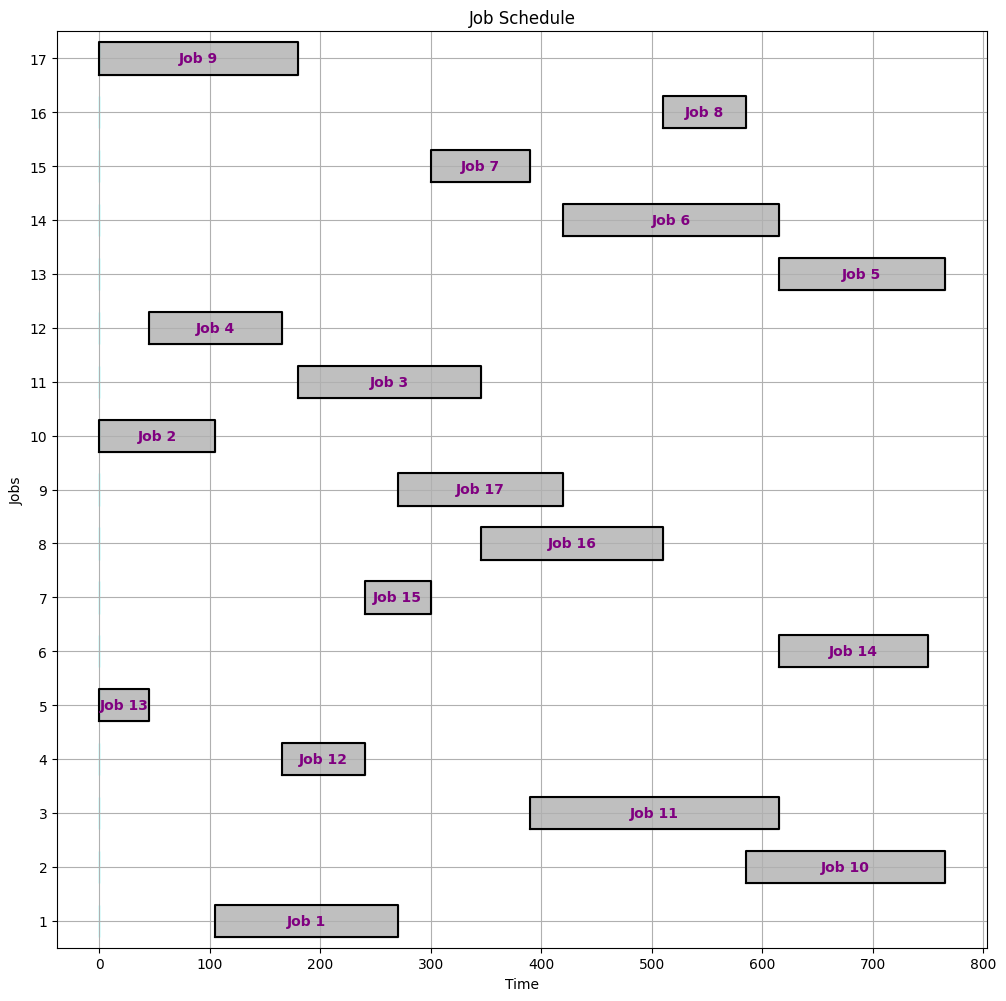

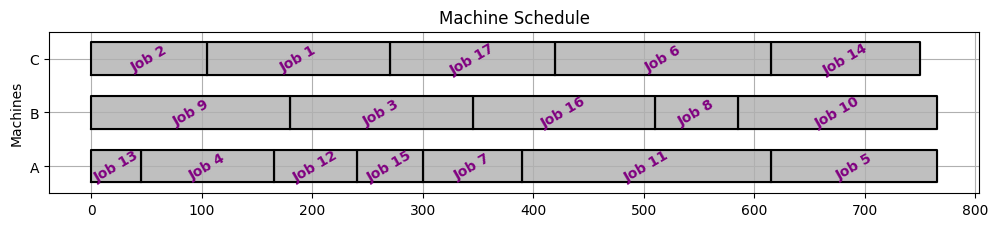

In [7]:
SCHEDULE = milp(JOBS, MACHINES)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

<span style="color: orange">Optimal schedule </span>

### LPT

['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


{'Makespan': 840,
 'Max Pastdue': 840,
 'Sum of Pastdue': 7665,
 'Number Pastdue': 17,
 'Number on Time': 0,
 'Fraction on Time': 0.0}

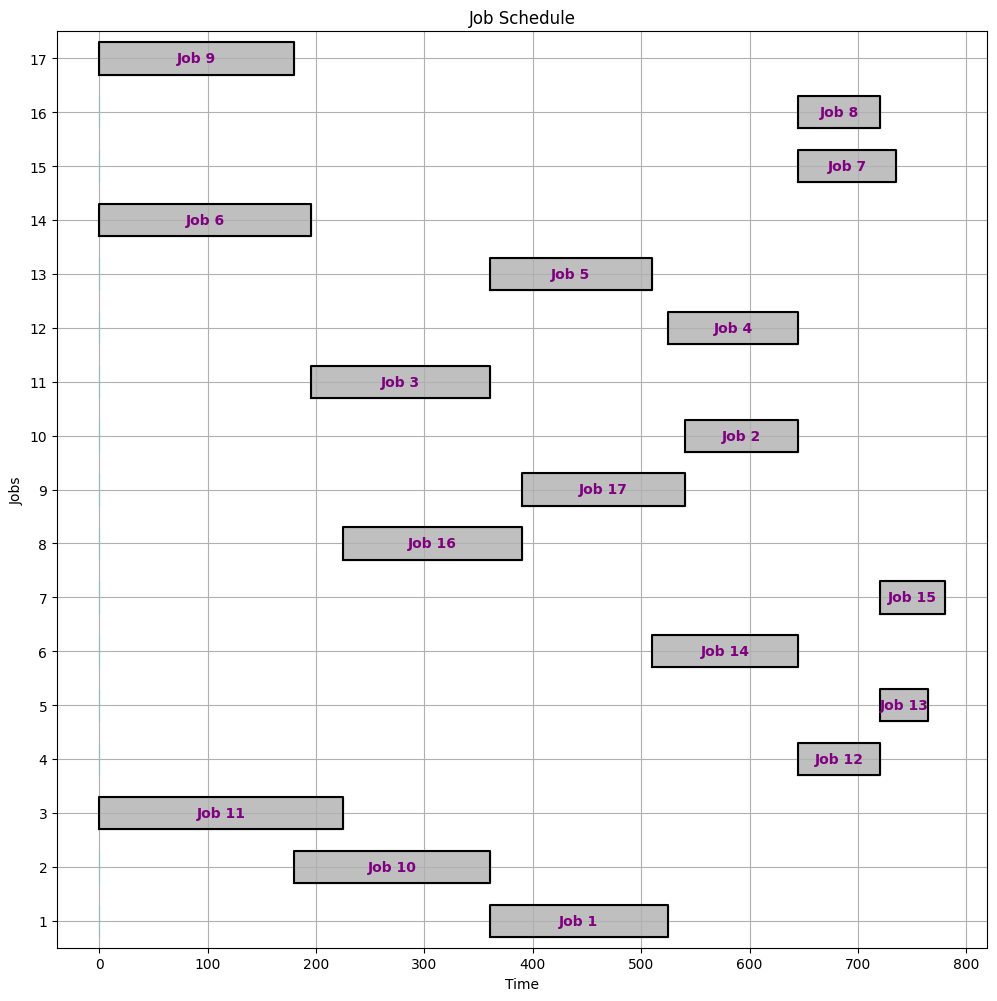

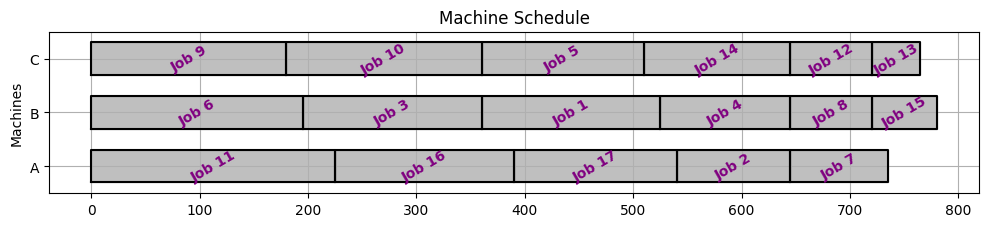

In [8]:
SCHEDULE = schedule(JOBS)
SCHEDULE
order=sorted(JOBS,reverse = True, key=lambda x: (JOBS[x]['duration'], x))

gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))
print(sorted(SCHEDULE.keys()))
kpi(JOBS, SCHEDULE)

### WSPT

['15', '7', '2', '17', '3', '16', '13', '8', '12', '9', '6', '4', '14', '5', '1', '10', '11']
[0.006060606060606061, 0.02857142857142857, 0.024242424242424242, 0.008333333333333333, 0.006666666666666667, 0.010256410256410256, 0.03333333333333333, 0.013333333333333334, 0.011111111111111112, 0.005555555555555556, 0.0044444444444444444, 0.013333333333333334, 0.022222222222222223, 0.007407407407407408, 0.05, 0.024242424242424242, 0.02666666666666667]


{'Makespan': 825,
 'Max Pastdue': 825,
 'Sum of Pastdue': 6795,
 'Number Pastdue': 17,
 'Number on Time': 0,
 'Fraction on Time': 0.0}

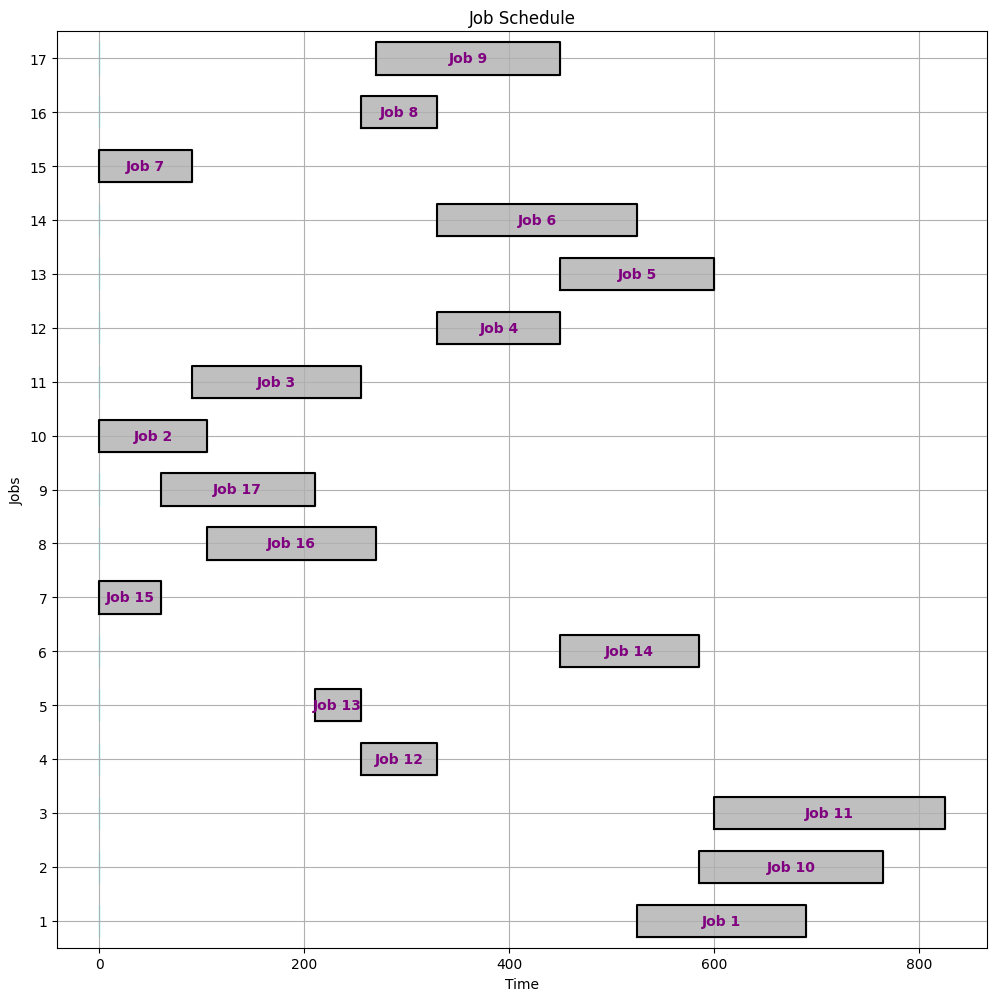

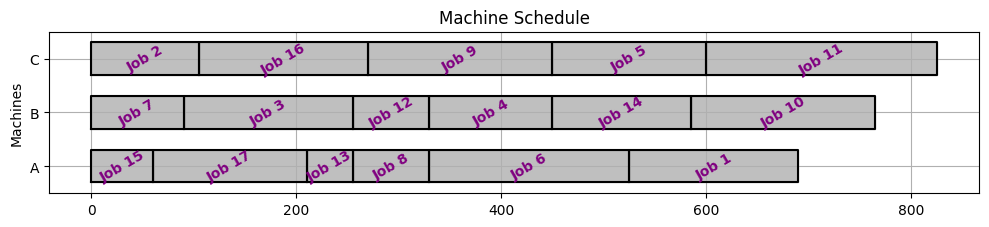

In [9]:
order=sorted(JOBS,reverse = True, key=lambda x: (JOBS[x]['weight']/JOBS[x]['duration'], x))
print(order)
print([JOBS[x]['weight']/JOBS[x]['duration'] for x in JOBS]) #it prints not in order
gantt(JOBS, schedule(JOBS,order)) 
kpi(JOBS, schedule(JOBS,order))

### SPT

['13', '15', '12', '8', '7', '2', '4', '14', '17', '5', '1', '16', '3', '10', '9', '6', '11']


{'Makespan': 855,
 'Max Pastdue': 855,
 'Sum of Pastdue': 6285,
 'Number Pastdue': 17,
 'Number on Time': 0,
 'Fraction on Time': 0.0}

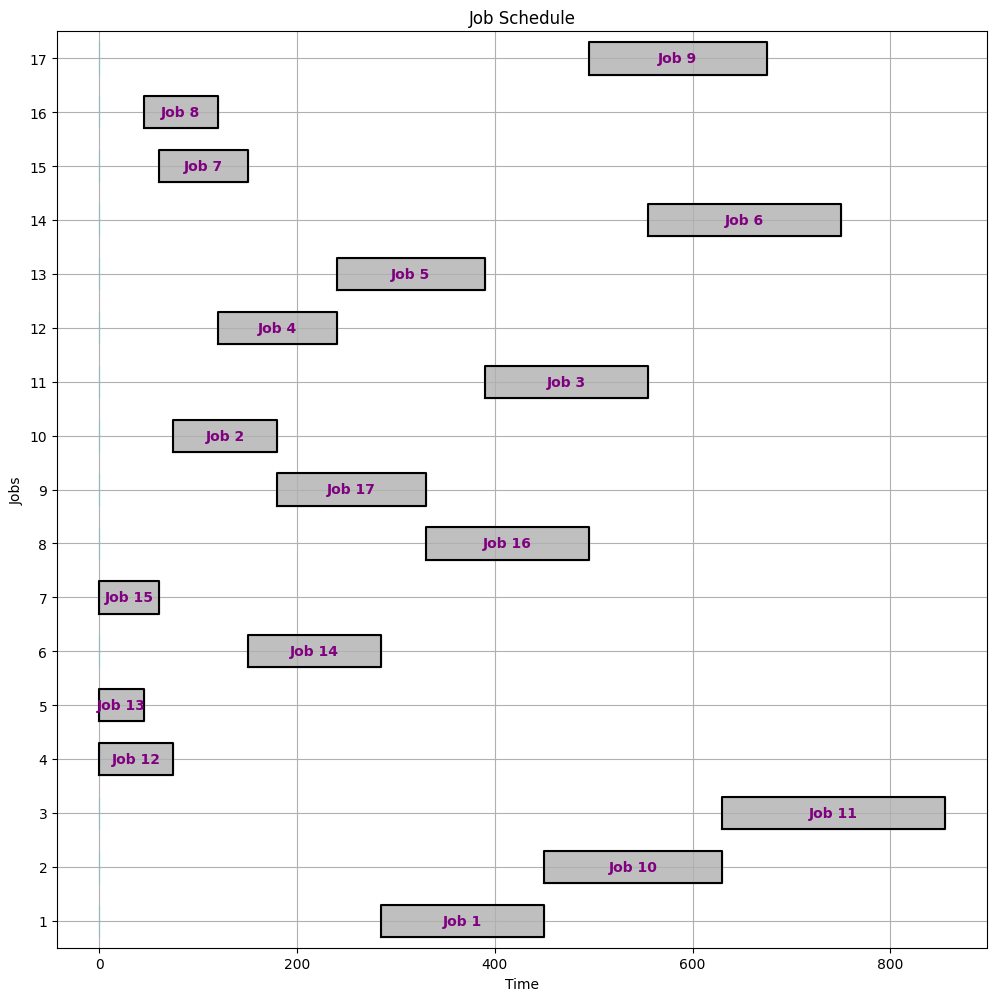

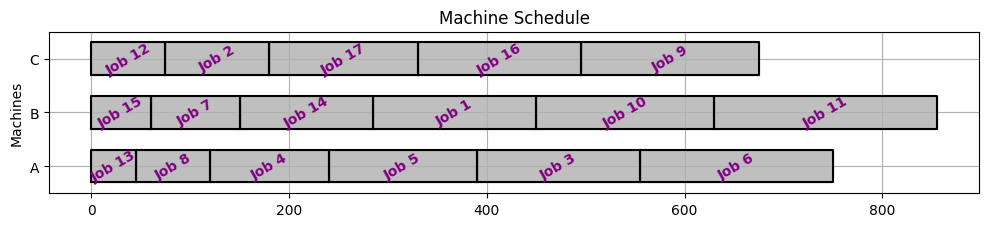

In [10]:
order=sorted(JOBS, key=lambda x: (JOBS[x]['duration'], x))
print(order)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

### Flow time

takes too much time to compute..

### Table of order based on each rules

In [11]:
def print_job_order(JOBS, order):
    data = {
        'Job': [],
        'Start (min)': [],
        'Duration (min)': [],
        'Due (min)': [],
        'Weight': []
    }
    
    for job in order:
        data['Job'].append(job)
        data['Start (min)'].append(JOBS[job]['release'])
        data['Duration (min)'].append(JOBS[job]['duration'])
        data['Due (min)'].append(JOBS[job]['due'])
        data['Weight'].append(JOBS[job]['weight'])
        
    df = pd.DataFrame(data)
    display(df)

# LPT - Largest Processing Time first
lpt_order = sorted(JOBS, reverse=True, key=lambda x: (JOBS[x]['duration'], x))
print("LPT Order:")
print_job_order(JOBS, lpt_order)

# WSPT - Weighted Shortest Processing Time first
wspt_order = sorted(JOBS, reverse=True, key=lambda x: (JOBS[x]['weight'] / JOBS[x]['duration'], x))
print("\nWSPT Order:")
print_job_order(JOBS, wspt_order)

# SPT - Shortest Processing Time first
spt_order = sorted(JOBS, key=lambda x: (JOBS[x]['duration'], x))
print("\nSPT Order:")
print_job_order(JOBS, spt_order)

LPT Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,11,0,225,0,1
1,6,0,195,0,2
2,9,0,180,0,2
3,10,0,180,0,1
4,3,0,165,0,4
5,16,0,165,0,4
6,1,0,165,0,1
7,5,0,150,0,1
8,17,0,150,0,4
9,14,0,135,0,1



WSPT Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,15,0,60,0,3
1,7,0,90,0,3
2,2,0,105,0,3
3,17,0,150,0,4
4,3,0,165,0,4
5,16,0,165,0,4
6,13,0,45,0,1
7,8,0,75,0,1
8,12,0,75,0,1
9,9,0,180,0,2



SPT Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,13,0,45,0,1
1,15,0,60,0,3
2,12,0,75,0,1
3,8,0,75,0,1
4,7,0,90,0,3
5,2,0,105,0,3
6,4,0,120,0,1
7,14,0,135,0,1
8,17,0,150,0,4
9,5,0,150,0,1


<span style="color: orange">
Why LPT is best heuristic :

because based on the course material, the Largest-Processing-Time-first (LPT) heuristic is recommended as the best heuristic method to minimize the duration in scheduling. This method sequences jobs to be processed on a resource in descending order of their processing times. It is particularly effective for minimizing the makespan on identical parallel machines by assigning each job to the machine with the least start time. This approach is illustrated and recommended for its effectiveness in achieving good scheduling performance in minimizing the total processing time Analytics in Operations Management, pages 168-176.
 </span>

## Question 2
Now, consider that not all products are ready at the beginning of the scheduling horizon.
Assume the release times given in the CSV file and create a new schedule based on the
fact that jobs cannot be processed before their release time. Does anything change? How?
What is the effect? Describe the characteristics of the new schedule and justify the chosen
modeling approach.
From now on, keep the release time in your modeling:


In [12]:
JOBS = {
    '1': {'release': time_to_continuous_minutes('Tuesday', 16, 45), 'duration': 2 * 60 + 45, 'due': 0, 'weight': 1},
    '2': {'release': time_to_continuous_minutes('Monday', 15, 45), 'duration': 1 * 60 + 45, 'due': 0, 'weight': 3},
    '3': {'release': time_to_continuous_minutes('Monday', 17, 45), 'duration': 2 * 60 + 45, 'due': 0, 'weight': 4},
    '4': {'release': time_to_continuous_minutes('Monday', 8, 30), 'duration': 2 * 60, 'due': 0, 'weight': 1},
    '5': {'release': time_to_continuous_minutes('Monday', 10, 30), 'duration': 2 * 60 + 30, 'due': 0, 'weight': 1},
    '6': {'release': time_to_continuous_minutes('Tuesday', 16, 0), 'duration': 3 * 60 + 15, 'due': 0, 'weight': 2},
    '7': {'release': time_to_continuous_minutes('Tuesday', 16, 30), 'duration': 1 * 60 + 30, 'due': 0, 'weight': 3},
    '8': {'release': time_to_continuous_minutes('Tuesday', 17, 45), 'duration': 1 * 60 + 15, 'due': 0, 'weight': 1},
    '9': {'release': time_to_continuous_minutes('Monday', 13, 30), 'duration': 3 * 60, 'due': 0, 'weight': 2},
    '10': {'release': time_to_continuous_minutes('Monday', 17, 15), 'duration': 3 * 60, 'due': 0, 'weight': 1},
    '11': {'release': time_to_continuous_minutes('Tuesday', 15, 45), 'duration': 3 * 60 + 45, 'due': 0, 'weight': 1},
    '12': {'release': time_to_continuous_minutes('Monday', 15, 45), 'duration': 1 * 60 + 15, 'due': 0, 'weight': 1},
    '13': {'release': time_to_continuous_minutes('Monday', 15, 30), 'duration': 45, 'due': 0, 'weight': 1},
    '14': {'release': time_to_continuous_minutes('Monday', 9, 30), 'duration': 2 * 60 + 15, 'due': 0, 'weight': 1},
    '15': {'release': time_to_continuous_minutes('Tuesday', 13, 0), 'duration': 1 * 60, 'due': 0, 'weight': 3},
    '16': {'release': time_to_continuous_minutes('Tuesday', 17, 0), 'duration': 2 * 60 + 45, 'due': 0, 'weight': 4},
    '17': {'release': time_to_continuous_minutes('Monday', 15, 30), 'duration': 2 * 60 + 30, 'due': 0, 'weight': 4},
}

MACHINES = ['A', 'B', 'C']

JOBS

{'1': {'release': 1125, 'duration': 165, 'due': 0, 'weight': 1},
 '2': {'release': 465, 'duration': 105, 'due': 0, 'weight': 3},
 '3': {'release': 585, 'duration': 165, 'due': 0, 'weight': 4},
 '4': {'release': 30, 'duration': 120, 'due': 0, 'weight': 1},
 '5': {'release': 150, 'duration': 150, 'due': 0, 'weight': 1},
 '6': {'release': 1080, 'duration': 195, 'due': 0, 'weight': 2},
 '7': {'release': 1110, 'duration': 90, 'due': 0, 'weight': 3},
 '8': {'release': 1185, 'duration': 75, 'due': 0, 'weight': 1},
 '9': {'release': 330, 'duration': 180, 'due': 0, 'weight': 2},
 '10': {'release': 555, 'duration': 180, 'due': 0, 'weight': 1},
 '11': {'release': 1065, 'duration': 225, 'due': 0, 'weight': 1},
 '12': {'release': 465, 'duration': 75, 'due': 0, 'weight': 1},
 '13': {'release': 450, 'duration': 45, 'due': 0, 'weight': 1},
 '14': {'release': 90, 'duration': 135, 'due': 0, 'weight': 1},
 '15': {'release': 900, 'duration': 60, 'due': 0, 'weight': 3},
 '16': {'release': 1140, 'duration':

### MILP

{'1': {'machine': 'C', 'start': 1200.0000000000002, 'finish': 1365.0000000000002}, '2': {'machine': 'A', 'start': 465.0, 'finish': 570.0}, '3': {'machine': 'A', 'start': 585.0, 'finish': 750.0}, '4': {'machine': 'B', 'start': 30.0, 'finish': 150.0}, '5': {'machine': 'A', 'start': 225.00000000000085, 'finish': 375.00000000000085}, '6': {'machine': 'B', 'start': 1080.0, 'finish': 1275.0}, '7': {'machine': 'C', 'start': 1110.0, 'finish': 1200.0}, '8': {'machine': 'A', 'start': 1290.0, 'finish': 1365.0}, '9': {'machine': 'B', 'start': 854.9999999999991, 'finish': 1034.999999999999}, '10': {'machine': 'C', 'start': 555.0, 'finish': 735.0}, '11': {'machine': 'A', 'start': 1065.0, 'finish': 1290.0}, '12': {'machine': 'C', 'start': 465.0, 'finish': 540.0}, '13': {'machine': 'B', 'start': 1034.9999999999998, 'finish': 1079.9999999999998}, '14': {'machine': 'A', 'start': 90.0, 'finish': 225.0}, '15': {'machine': 'A', 'start': 900.0, 'finish': 960.0}, '16': {'machine': 'B', 'start': 1275.00000000

{'Makespan': 1440.0000000000002,
 'Max Pastdue': 1440.0000000000002,
 'Sum of Pastdue': 14955.0,
 'Number Pastdue': 17,
 'Number on Time': 0,
 'Fraction on Time': 0.0}

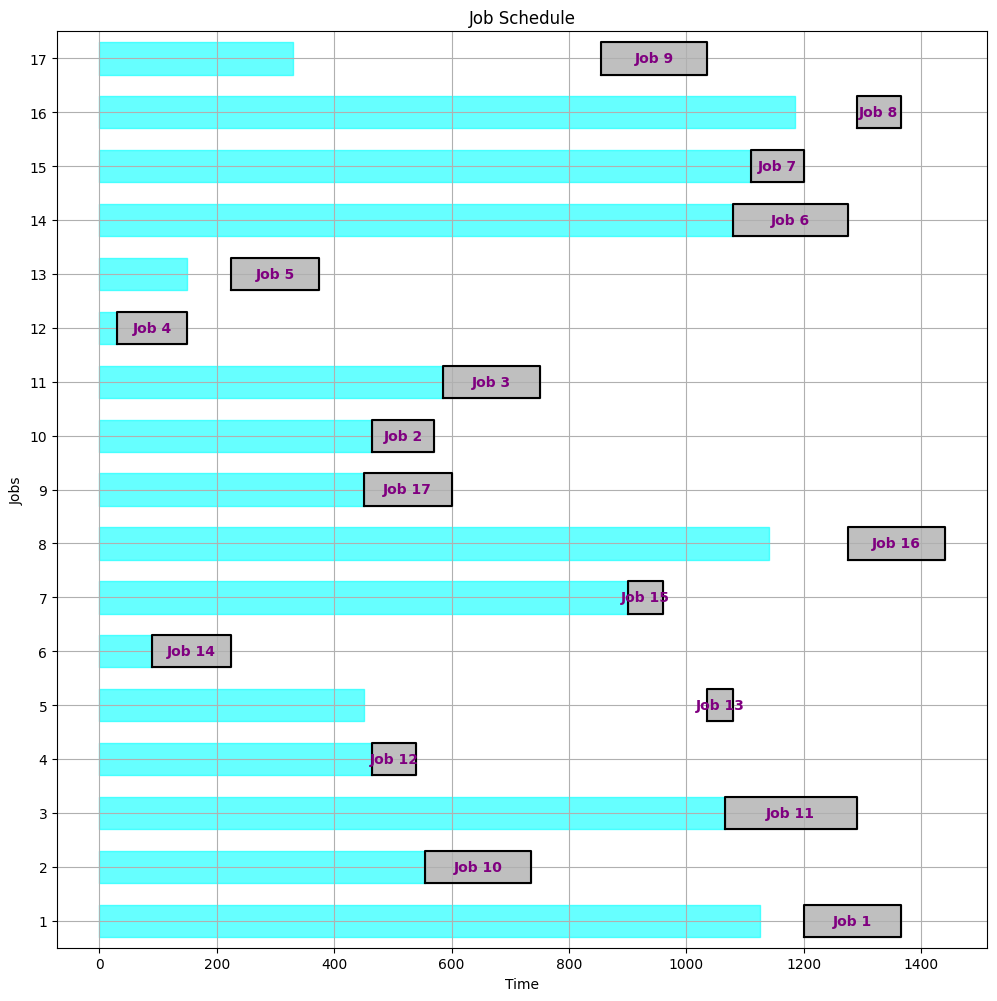

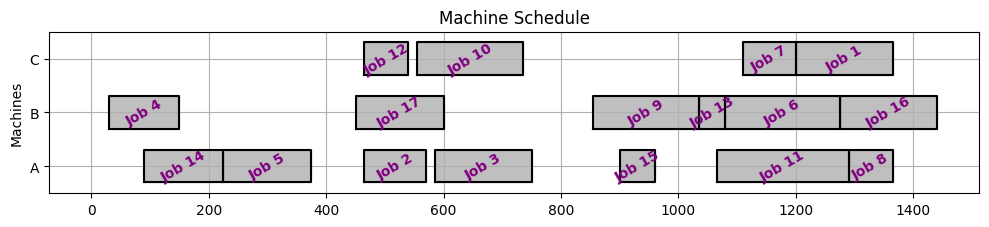

In [13]:
SCHEDULE = milp(JOBS, MACHINES)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

### LPT

LPT Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,11,1065,225,0,1
1,6,1080,195,0,2
2,9,330,180,0,2
3,10,555,180,0,1
4,3,585,165,0,4
5,16,1140,165,0,4
6,1,1125,165,0,1
7,5,150,150,0,1
8,17,450,150,0,4
9,14,90,135,0,1


{'Makespan': 1695,
 'Max Pastdue': 1695,
 'Sum of Pastdue': 23370,
 'Number Pastdue': 17,
 'Number on Time': 0,
 'Fraction on Time': 0.0}

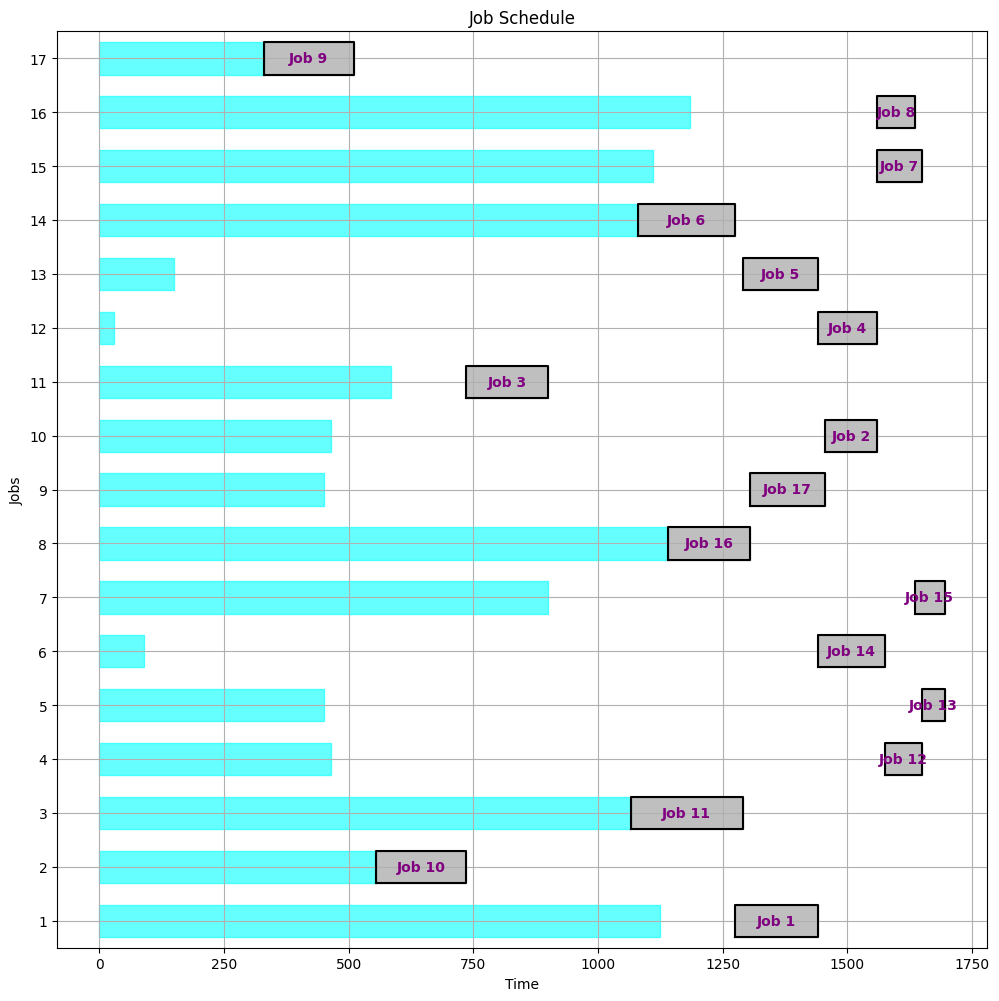

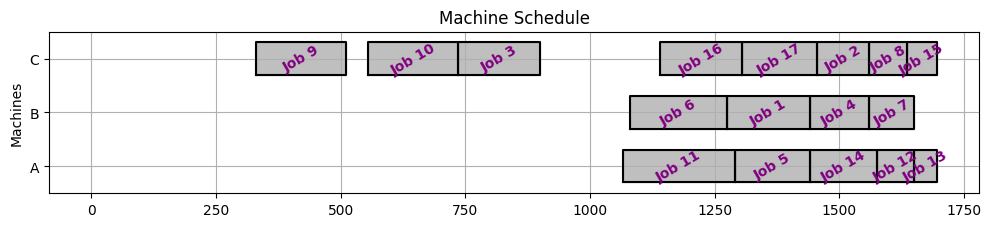

In [14]:
SCHEDULE = schedule(JOBS)
SCHEDULE

order=sorted(JOBS,reverse = True, key=lambda x: (JOBS[x]['duration'], x))
print("LPT Order:")
print_job_order(JOBS, order)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

## Question 3

## 3.1
There has been an unexpected surge in demand for certain products in the market, prompting the company to prioritize their handling. Could you explain the new objective and schedule requirements? 


In [15]:
JOBS = {
    '1': {'release': time_to_continuous_minutes('Tuesday', 16, 45), 'duration': 2 * 60 + 45, 'due': time_to_continuous_minutes('Wednesday', 10, 30), 'weight': 1},
    '2': {'release': time_to_continuous_minutes('Monday', 15, 45), 'duration': 1 * 60 + 45, 'due': time_to_continuous_minutes('Wednesday', 12, 0), 'weight': 3},
    '3': {'release': time_to_continuous_minutes('Monday', 17, 45), 'duration': 2 * 60 + 45, 'due': time_to_continuous_minutes('Thursday', 11, 45), 'weight': 4},
    '4': {'release': time_to_continuous_minutes('Monday', 8, 30), 'duration': 2 * 60, 'due': time_to_continuous_minutes('Wednesday', 13, 45), 'weight': 1},
    '5': {'release': time_to_continuous_minutes('Monday', 10, 30), 'duration': 2 * 60 + 30, 'due': time_to_continuous_minutes('Tuesday', 8, 30), 'weight': 1},
    '6': {'release': time_to_continuous_minutes('Tuesday', 16, 0), 'duration': 3 * 60 + 15, 'due': time_to_continuous_minutes('Thursday', 17, 30), 'weight': 2},
    '7': {'release': time_to_continuous_minutes('Tuesday', 16, 30), 'duration': 1 * 60 + 30, 'due': time_to_continuous_minutes('Wednesday', 13, 30), 'weight': 3},
    '8': {'release': time_to_continuous_minutes('Tuesday', 17, 45), 'duration': 1 * 60 + 15, 'due': time_to_continuous_minutes('Friday', 9, 45), 'weight': 1},
    '9': {'release': time_to_continuous_minutes('Monday', 13, 30), 'duration': 3 * 60, 'due': time_to_continuous_minutes('Thursday', 14, 15), 'weight': 2},
    '10': {'release': time_to_continuous_minutes('Monday', 17, 15), 'duration': 3 * 60, 'due': time_to_continuous_minutes('Wednesday', 12, 30), 'weight': 1},
    '11': {'release': time_to_continuous_minutes('Tuesday', 15, 45), 'duration': 3 * 60 + 45, 'due': time_to_continuous_minutes('Thursday', 13, 30), 'weight': 1},
    '12': {'release': time_to_continuous_minutes('Monday', 15, 45), 'duration': 1 * 60 + 15, 'due': time_to_continuous_minutes('Tuesday', 15, 0), 'weight': 1},
    '13': {'release': time_to_continuous_minutes('Monday', 15, 30), 'duration': 45, 'due': time_to_continuous_minutes('Tuesday', 16, 45), 'weight': 1},
    '14': {'release': time_to_continuous_minutes('Monday', 9, 30), 'duration': 2 * 60 + 15, 'due': time_to_continuous_minutes('Tuesday', 13, 30), 'weight': 1},
    '15': {'release': time_to_continuous_minutes('Tuesday', 13, 0), 'duration': 1 * 60, 'due': time_to_continuous_minutes('Tuesday', 15, 45), 'weight': 3},
    '16': {'release': time_to_continuous_minutes('Tuesday', 17, 0), 'duration': 2 * 60 + 45, 'due': time_to_continuous_minutes('Friday', 17, 0), 'weight': 4},
    '17': {'release': time_to_continuous_minutes('Monday', 15, 30), 'duration': 2 * 60 + 30, 'due': time_to_continuous_minutes('Wednesday', 8, 45), 'weight': 4},
}

MACHINES = ['A', 'B', 'C']

<span style="color: orange">
need to take `due date` into account p.144. New objective using SPT or EDD.
</span>

### SPT


EDD Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,13,450,45,1125,1
1,15,900,60,1065,3
2,12,465,75,1020,1
3,8,1185,75,2505,1
4,7,1110,90,1530,3
5,2,465,105,1440,3
6,4,30,120,1545,1
7,14,90,135,930,1
8,17,450,150,1245,4
9,5,150,150,630,1


{'Makespan': 1785,
 'Max Pastdue': 960,
 'Sum of Pastdue': 1290,
 'Number Pastdue': 4,
 'Number on Time': 13,
 'Fraction on Time': 0.7647058823529411}

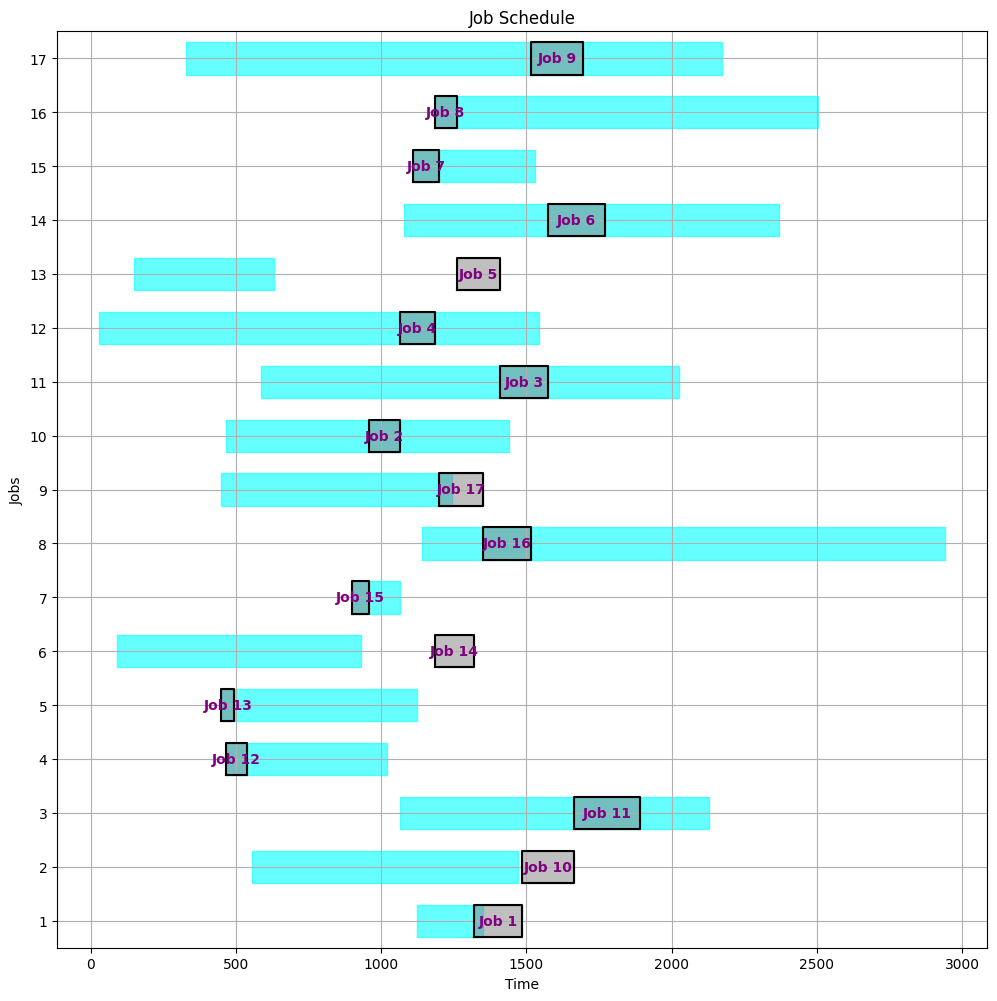

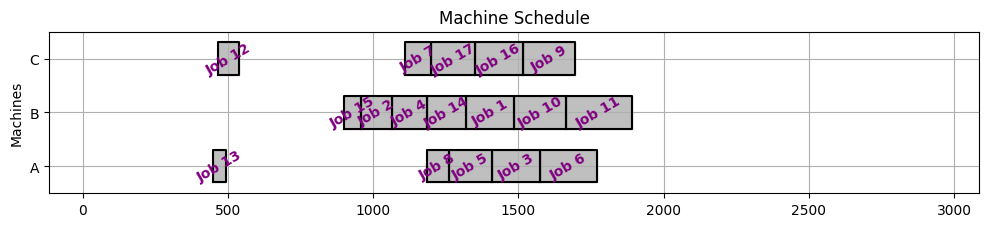

In [16]:
order=sorted(JOBS, key=lambda x: (JOBS[x]['duration'], x))
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))
# SPT 
print("\nEDD Order:")
print_job_order(JOBS, order)
kpi(JOBS, SCHEDULE)


### EDD


EDD Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,5,150,150,630,1
1,14,90,135,930,1
2,12,465,75,1020,1
3,15,900,60,1065,3
4,13,450,45,1125,1
5,17,450,150,1245,4
6,1,1125,165,1350,1
7,2,465,105,1440,3
8,10,555,180,1470,1
9,7,1110,90,1530,3


{'Makespan': 1785,
 'Max Pastdue': 960,
 'Sum of Pastdue': 1290,
 'Number Pastdue': 4,
 'Number on Time': 13,
 'Fraction on Time': 0.7647058823529411}

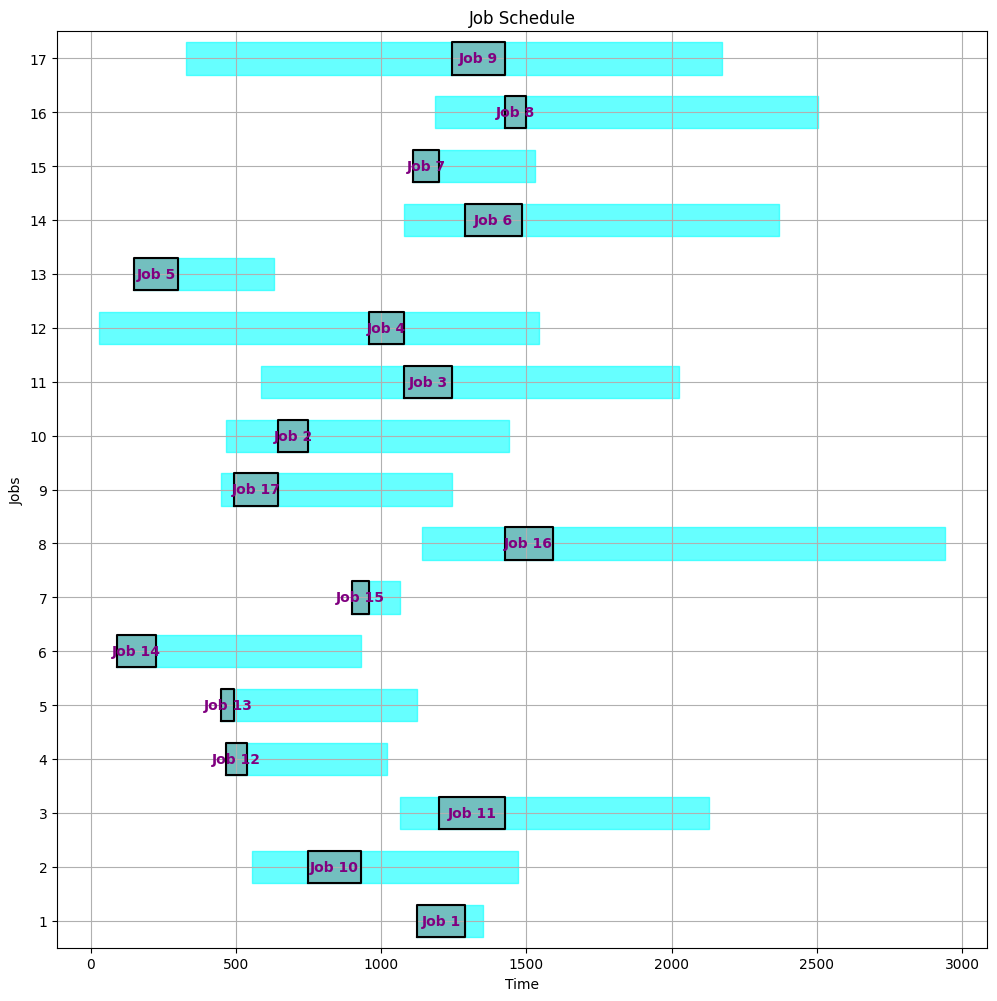

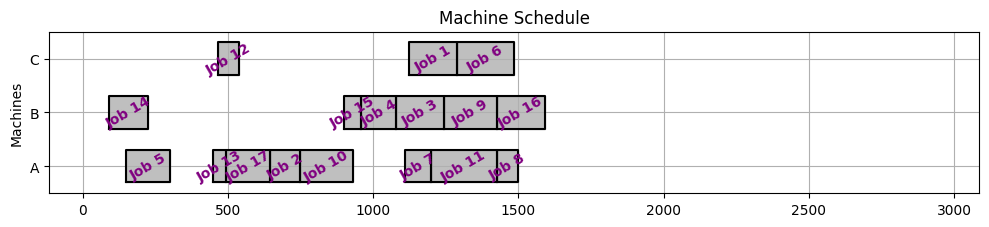

In [17]:
order = sorted(JOBS, key=lambda x: (JOBS[x]['due'], x))
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))
# EDD - Earliest Due Date first
print("\nEDD Order:")
print_job_order(JOBS, order)
kpi(JOBS, SCHEDULE)


## 3.2
Additionally, explore an alternative approach that could be used to achieve an optimal or near-optimal schedule, and explain the differences between the two.

<span style="color: orange">
Optimization through maximum lateness or number of tardy jobs and Moore hodson algo ??
</span>

### Mathematical model
#### Max lateness

-60.00000000000001


{'Makespan': 2714.9999999999995,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 17,
 'Fraction on Time': 1.0}

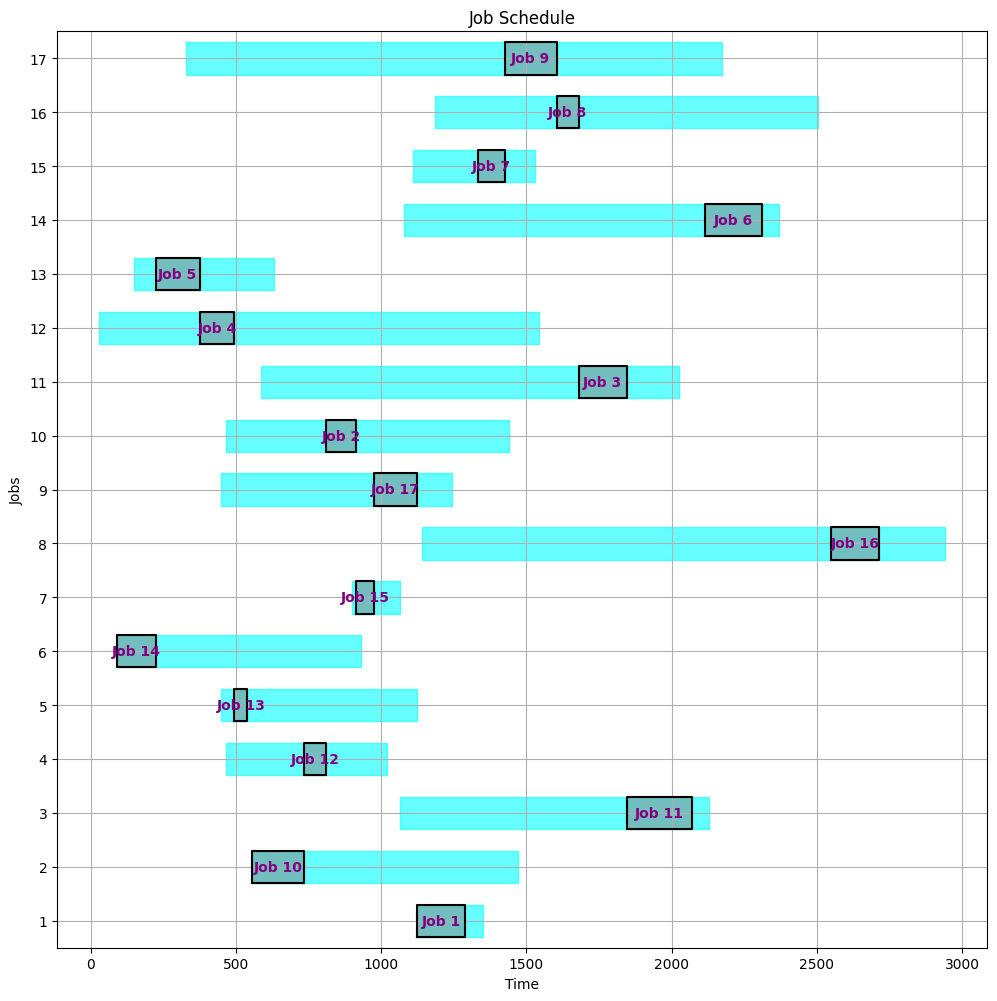

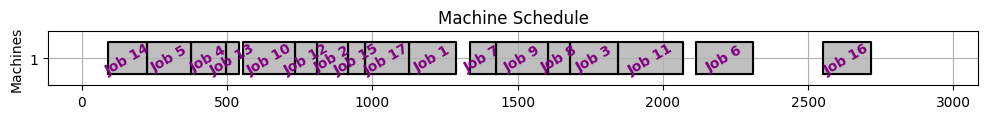

In [18]:
def opt_schedule(JOBS):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # upper bounds on how long it would take to process all jobs
    tmax = max([JOBS[job_id]['release'] for job_id in JOBS.keys()]) + sum([JOBS[job_id]['duration'] for job_id in JOBS.keys()])


    # decision variables
    completion_time = []
    auxilaryVar = []
    for job in range(len(JOBS.keys())):
        suffix = '_%s' % job
        completion_time.append(m.NumVar(0, tmax, 'complete' + suffix))

        auxilaryVar_nested=[]
        for job_k in JOBS.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)


    # additional decision variables for use in the objecive
    maxpastdue = m.NumVar(-tmax, tmax, 'maxpastdue')

    # constraints
    for j,job_id in enumerate(JOBS.keys()):
        m.Add(completion_time[j] >= JOBS[job_id]['release'] + JOBS[job_id]['duration'])
        m.Add(maxpastdue >= completion_time[j] - JOBS[job_id]['due'])
        for k,job_id_k in enumerate(JOBS.keys()):
            if k !=j:
                m.Add(completion_time[j] + JOBS[job_id_k]['duration'] <= completion_time[k] + tmax*auxilaryVar[j][k])
                m.Add(completion_time[k] + JOBS[job_id]['duration'] <= completion_time[j] + tmax*(1 - auxilaryVar[j][k]))

    # objective function
    m.Minimize(maxpastdue)

    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print(maxpastdue.solution_value())
        SCHEDULE = {}
        for j,job_id in enumerate(JOBS.keys()):
            SCHEDULE[job_id] = {'machine': 1, 'start': completion_time[j].solution_value() - JOBS[job_id]['duration'], 'finish': completion_time[j].solution_value()}
        # print(SCHEDULE)
        return SCHEDULE


    else:
        print('The problem does not have an optimal solution.')


SCHEDULE = opt_schedule(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

#### Number of delayed jobs

0.0


{'Makespan': 2939.9999999999995,
 'Max Pastdue': 4.547473508864641e-13,
 'Sum of Pastdue': 4.547473508864641e-13,
 'Number Pastdue': 1,
 'Number on Time': 16,
 'Fraction on Time': 0.9411764705882353}

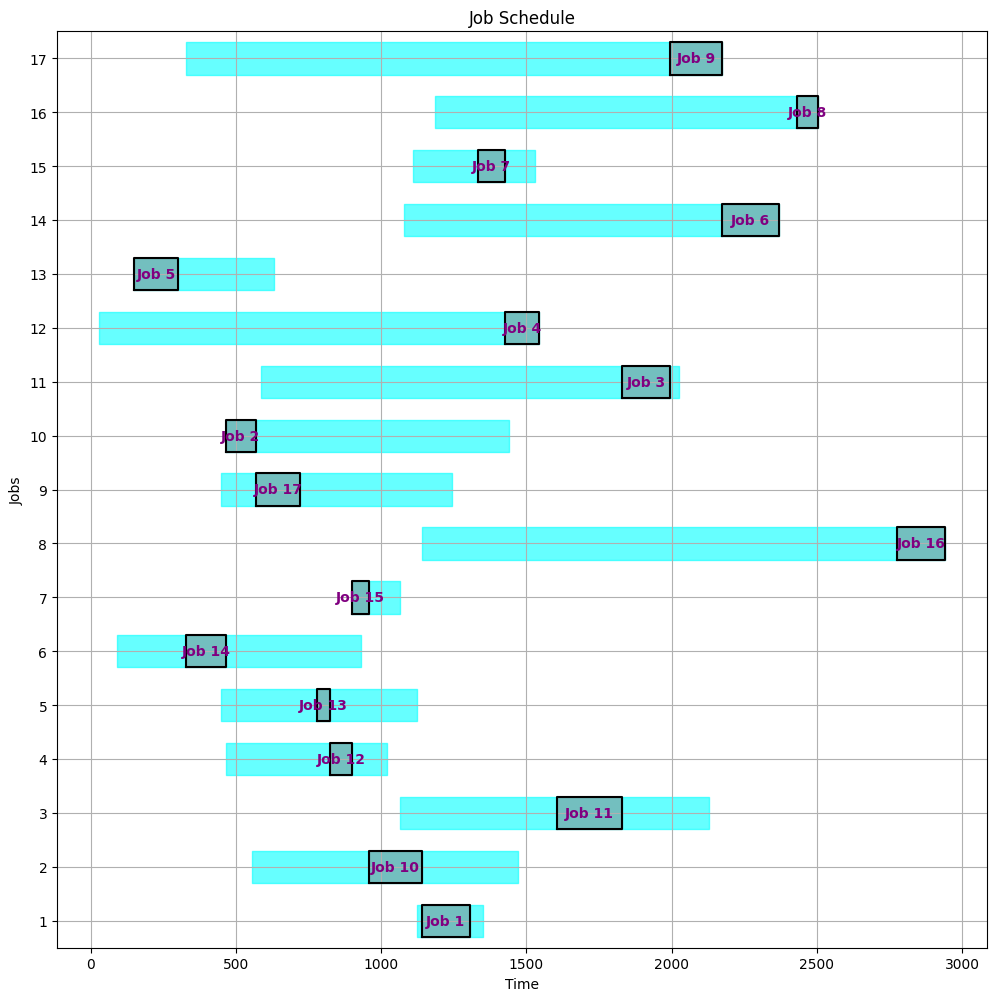

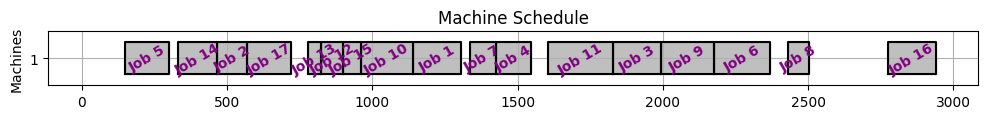

In [19]:
def opt_schedule(JOBS):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # upper bounds on how long it would take to process all jobs
    tmax = max([JOBS[job_id]['release'] for job_id in JOBS.keys()]) + sum([JOBS[job_id]['duration'] for job_id in JOBS.keys()])


    # decision variables
    completion_time = []
    auxilaryVar = []
    for job in range(len(JOBS.keys())):
        suffix = '_%s' % job
        completion_time.append(m.NumVar(0, tmax, 'complete' + suffix))

        auxilaryVar_nested=[]
        for job_k in JOBS.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)


    # additional decision variables for use in the objecive
    ispastdue = []
    for job_id in JOBS.keys():
        ispastdue.append(m.BoolVar('ispastdue'))

    # constraints
    for j,job_id in enumerate(JOBS.keys()):
        m.Add(completion_time[j] <= JOBS[job_id]['due'] + tmax * ispastdue[j])

        m.Add(completion_time[j] >= JOBS[job_id]['release'] + JOBS[job_id]['duration'])
        for k,job_id_k in enumerate(JOBS.keys()):
            if k !=j:
                m.Add(completion_time[j] + JOBS[job_id_k]['duration'] <= completion_time[k] + tmax*auxilaryVar[j][k])
                m.Add(completion_time[k] + JOBS[job_id]['duration'] <= completion_time[j] + tmax*(1 - auxilaryVar[j][k]))

    # objective function
    m.Minimize(sum(ispastdue))

    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print(sum(ispastdue[job_id].solution_value() for job_id in range(len(JOBS.keys()))))
        SCHEDULE = {}
        for j,job_id in enumerate(JOBS.keys()):
            SCHEDULE[job_id] = {'machine': 1, 'start': completion_time[j].solution_value() - JOBS[job_id]['duration'], 'finish': completion_time[j].solution_value()}
        # print(SCHEDULE)
        return SCHEDULE


    else:
        print('The problem does not have an optimal solution.')


SCHEDULE = opt_schedule(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

#### Moore and Hudson Algo

In [20]:
order = sorted(JOBS, key=lambda x: (JOBS[x]['due'], x))
# print(order)

Flow_Time = []
j = 0
while j < len(order):
    job = order[j]
    # print(j,job)
    if len(Flow_Time) == 0:
        Flow_Time.append(JOBS[job]['duration'])
    else:
        Flow_Time.append(Flow_Time[-1] + JOBS[job]['duration'])
    # print(Flow_Time)
    if Flow_Time[j] > JOBS[job]['due']:
        remove_ele = np.argmax(np.array([JOBS[i]['duration'] for i in order[:j]]))
        order.pop(remove_ele)
        j = 0
        Flow_Time = []
    else:
        j += 1
    # print(order)

df = pd.DataFrame(np.column_stack((order,np.array([JOBS[job]['duration'] for job in order]),np.array([JOBS[job]['due'] for job in order]),Flow_Time)))
df.columns = ['Job','Processing Time','Due Date','Flow Time']
df.style

,Job,Processing Time,Due Date,Flow Time
0,5,150,630,150
1,14,135,930,285
2,12,75,1020,360
3,15,60,1065,420
4,13,45,1125,465
5,17,150,1245,615
6,1,165,1350,780
7,2,105,1440,885
8,10,180,1470,1065
9,7,90,1530,1155


## 3.3


Another way to address the urgency of producing certain products is by imposing deadlines for their delivery. Considering deadlines introduces various objectives, each with distinct  implications for scheduling:

    (a) Minimizing the overall delay from deadlines.
    (b) Minimizing the maximum delay between deadlines and product completion time.
    This could be due to the difficulty of storing some products as inventory.
    (c) Minimizing the overall deviation of deadlines and product completion time.
    (d) Minimizing the maximum deviation between deadlines and product completion time.
    (e) Minimizing the number of products for which the deadline could not be accommodated.
    
Remember to prioritize tasks whenever possible!

<span style="color: orange">
so

- (a) used in q. 3.2 through number of tardy jobs
- (b) q.3.2 max lateness
- (c) ??
- (d) q.3.2 max lateness
- (e) q.3.2 moore hudson
</span>

## Question 4

Constraint Analysis for Parallel-Machine Scheduling Model

### Constraints Description
The constraints governing the scheduling of jobs on parallel machines can be described as follows:

1. **Time Scheduling Constraint**:
   $$
   C_j + p_k \leq C_k + M(2 - x_{jm} - x_{km} + y_{jk}) \quad \forall j, k, m
   $$
   This constraint ensures that if job \(j\) is scheduled before job \(k\) on any machine \(m\), then the completion time of job \(j\) plus the processing time of job \(k\) is less than or equal to the completion time of job \(k\), adjusted by a large constant \(M\) times the condition of sequencing and machine assignment.

2. **Mutual Exclusivity Constraint**:
   $$
   C_k + p_j \leq C_j + M(3 - y_{jk} - x_{jm} - x_{km}) \quad \forall j, k, m
   $$
   This ensures that two jobs cannot overlap in their scheduling unless the sequence and machine allocations are appropriately set.

3. **Non-negativity Constraint**:
   $$
   C_j \geq 0 \quad \forall j
   $$
   The completion times of all jobs must be non-negative.

4. **Binary Constraint for Job Sequencing**:
   $$
   y_{jk} \in \{0, 1\} \quad \forall j, k
   $$
   This binary variable indicates whether job \(k\) is processed after job \(j\).

### Parameters and Variables


- Processing time of job \( j \):
  $$
  p_j
  $$

- A large number (Big M):
  $$
  M
  $$

- Maximum completion time on all machines:
  $$
  C_{\text{max}}
  $$

- Completion time of job \( j \):
  $$
  C_j
  $$

- Binary variable, 1 if job \( k \) is processed after job \( j \) (job sequencing):
  $$
  y_{jk}
  $$

- Binary variable, 1 if job \( j \) is processed on machine \( m \) (machine assignment):
  $$
  x_{jm}
  $$

### Optimization Model
The objective is to minimize the maximum completion time across all machines:
$$
\min C_{\text{max}}
$$
subject to:
$$
\sum_{j} x_{jm}p_j \leq C_{\text{max}} \quad \forall m
$$
$$
\sum_{m} x_{jm} = 1 \quad \forall j
$$
$$
x_{jm} \in \{0, 1\} \quad \forall j, m
$$

### Additional Constraints Needed

To complete the model, additional constraints are required to fully capture the scheduling problem:

**Machine Capacity Constraint**: Ensuring that each job is assigned to exactly one machine.

$$
\sum_{m} x_{jm} = 1 \quad \forall j
$$

This ensures that each job \( j \) is assigned to exactly one machine \( m \).

**Completion Time Constraint**: Ensuring that the completion time of each job does not exceed the maximum completion time \( C_{\text{max}} \).

$$
\sum_{j} x_{jm} p_j \leq C_{\text{max}} \quad \forall m
$$

This ensures that the total processing time on any machine \( m \) does not exceed \( C_{\text{max}} \).

**Binary Assignment**: Ensuring binary values for machine assignment variables.

$$
x_{jm} \in \{0, 1\} \quad \forall j, m
$$

### Integration of the Additional Constraints

When integrated with the given constraints, the model ensures proper scheduling of jobs on parallel machines while minimizing the makespan:

**Objective**:

$$
\min C_{\text{max}}
$$

**Constraints**:

$$
C_j + p_k \leq C_k + M(2 - x_{jm} - x_{km} + y_{jk}) \quad \forall j, k, m
$$

$$
C_k + p_j \leq C_j + M(3 - y_{jk} - x_{jm} - x_{km}) \quad \forall j, k, m
$$

$$
C_j \geq 0 \quad \forall j
$$

$$
y_{jk} \in \{0, 1\} \quad \forall j, k
$$

$$
\sum_{m} x_{jm} = 1 \quad \forall j
$$

$$
\sum_{j} x_{jm} p_j \leq C_{\text{max}} \quad \forall m
$$

$$
x_{jm} \in \{0, 1\} \quad \forall j, m
$$

### Justification

Based on the course materials, these constraints form a comprehensive model for parallel machine scheduling aimed at minimizing the makespan. The additional constraints ensure that each job is processed exactly once and the load on each machine does not exceed the specified maximum completion time, ensuring an optimal schedule.

### Course Reference

The constraints and methods align with the optimization models and heuristics for scheduling problems discussed in the course materials, particularly in sections focusing on multiple machines and minimizing the makespan:

- pages 165

## Question 6

WoodCraft Creations has decided to incorporate an inspection booth after the assembly
machines. They adhere to a full inspection policy to uphold the quality they promise. Full
inspection involves examining every product or component to ensure it meets specific standards
or requirements. At this station, an employee checks the products and assesses if they meet
expectations.
The file data project 2.csv provides the inspection time for each product.

Address this problem by taking into account the release time of each product at the completion of its assembly. Use the rules outlined below, ensuring that the priorities and
deadlines align with those mentioned in the previous section:
- LPT
- SPT
- EDD


In [21]:
data_2 = pd.read_csv('data/data_project_2.csv')
data_2

,Needed_Time (Hour)
0,1.899808
1,0.590951
2,2.127029
3,2.889249
4,2.554759
5,0.058992
6,0.901546
7,1.275430
8,0.838140
9,1.912403


In [22]:
# Convert inspection times to a list
inspection_times = [int(time * 60) for time in data_2['Needed_Time (Hour)']]
inspection_times

[113, 35, 127, 173, 153, 3, 54, 76, 50, 114, 78, 56, 27, 127, 53, 112, 99]

In [35]:
JOBS = {
    '1': {'release': 1365, 'duration': 113, 'due': time_to_continuous_minutes('Wednesday', 10, 30), 'weight': 1},
    '2': {'release': 570, 'duration': 35, 'due': time_to_continuous_minutes('Wednesday', 12, 0), 'weight': 3},
    '3': {'release': 750, 'duration': 127, 'due': time_to_continuous_minutes('Thursday', 11, 45), 'weight': 4},
    '4': {'release': 150, 'duration': 173, 'due': time_to_continuous_minutes('Wednesday', 13, 45), 'weight': 1},
    '5': {'release': 375, 'duration': 153, 'due': time_to_continuous_minutes('Tuesday', 8, 30), 'weight': 1},
    '6': {'release': 1275, 'duration': 3, 'due': time_to_continuous_minutes('Thursday', 17, 30), 'weight': 2},
    '7': {'release': 1200, 'duration': 54, 'due': time_to_continuous_minutes('Wednesday', 13, 30), 'weight': 3},
    '8': {'release': 1365, 'duration': 76, 'due': time_to_continuous_minutes('Friday', 9, 45), 'weight': 1},
    '9': {'release': 1035, 'duration': 50, 'due': time_to_continuous_minutes('Thursday', 14, 15), 'weight': 2},
    '10': {'release': 735, 'duration': 114, 'due': time_to_continuous_minutes('Wednesday', 12, 30), 'weight': 1},
    '11': {'release': 1290, 'duration': 78, 'due': time_to_continuous_minutes('Thursday', 13, 30), 'weight': 1},
    '12': {'release': 540, 'duration': 56, 'due': time_to_continuous_minutes('Tuesday', 15, 0), 'weight': 1},
    '13': {'release': 1080, 'duration': 27, 'due': time_to_continuous_minutes('Tuesday', 16, 45), 'weight': 1},
    '14': {'release': 225, 'duration': 127, 'due': time_to_continuous_minutes('Tuesday', 13, 30), 'weight': 1},
    '15': {'release': 960, 'duration': 53, 'due': time_to_continuous_minutes('Tuesday', 15, 45), 'weight': 3},
    '16': {'release': 1440, 'duration': 112, 'due': time_to_continuous_minutes('Friday', 17, 0), 'weight': 4},
    '17': {'release': 600, 'duration': 99, 'due': time_to_continuous_minutes('Wednesday', 8, 45), 'weight': 4},
}

MACHINES = ['I']

### LPT

LPT Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,4,150,173,1545,1
1,5,375,153,630,1
2,3,750,127,2025,4
3,14,225,127,930,1
4,10,735,114,1470,1
5,1,1365,113,1350,1
6,16,1440,112,2940,4
7,17,600,99,1245,4
8,11,1290,78,2130,1
9,8,1365,76,2505,1


{'Makespan': 2121,
 'Max Pastdue': 993,
 'Sum of Pastdue': 4533,
 'Number Pastdue': 8,
 'Number on Time': 9,
 'Fraction on Time': 0.5294117647058824}

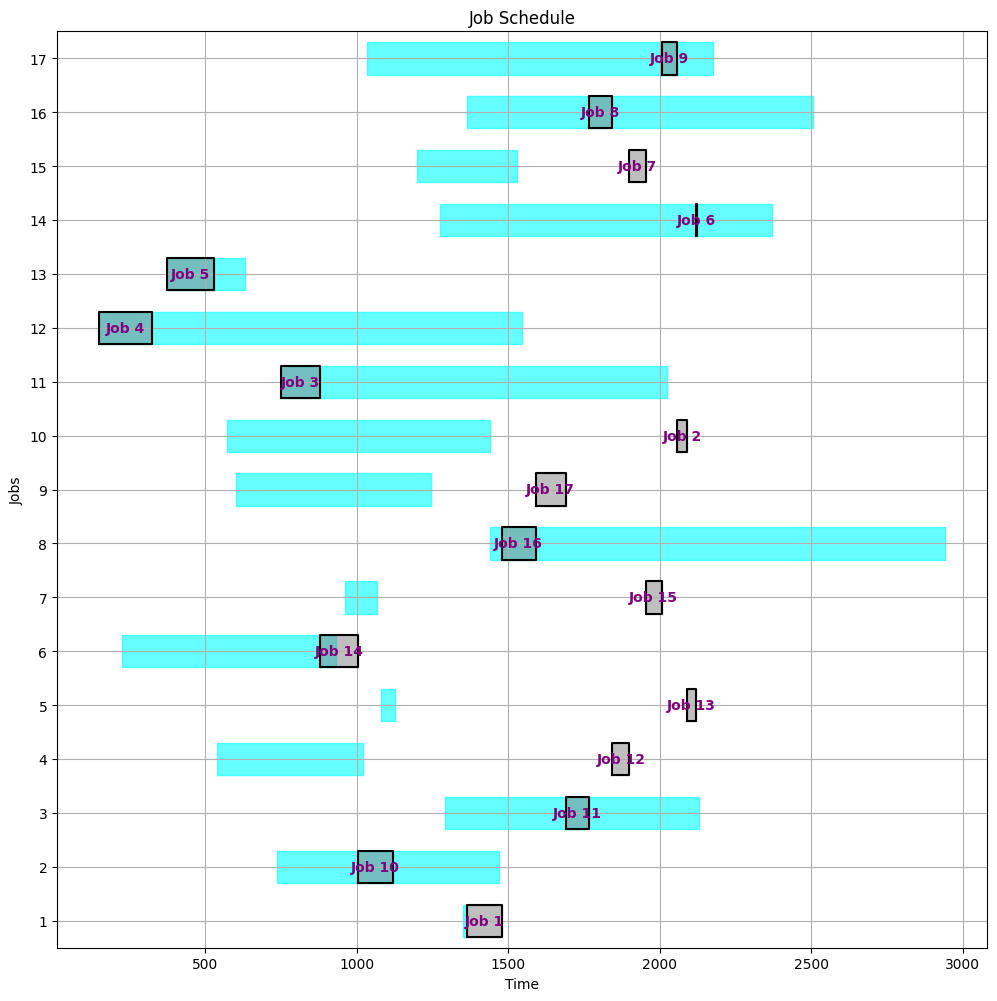

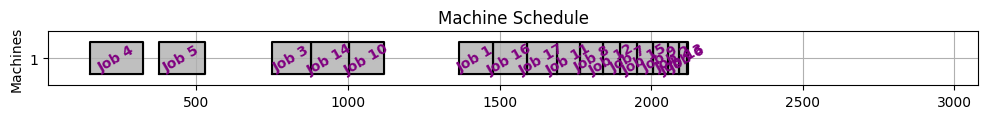

In [24]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    "Schedule a dictionary of JOBS on a single machine in a specified order."
    start = 0
    finish = 0
    SCHEDULE = {}

    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE

SCHEDULE = schedule(JOBS)
SCHEDULE

order=sorted(JOBS,reverse = True, key=lambda x: (JOBS[x]['duration'], x))
print("LPT Order:")
print_job_order(JOBS, order)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

### SPT


EDD Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,6,1275,3,2370,2
1,13,1080,27,1125,1
2,2,570,35,1440,3
3,9,1035,50,2175,2
4,15,960,53,1065,3
5,7,1200,54,1530,3
6,12,540,56,1020,1
7,8,1365,76,2505,1
8,11,1290,78,2130,1
9,17,600,99,1245,4


{'Makespan': 2815,
 'Max Pastdue': 2002,
 'Sum of Pastdue': 10581,
 'Number Pastdue': 15,
 'Number on Time': 2,
 'Fraction on Time': 0.11764705882352941}

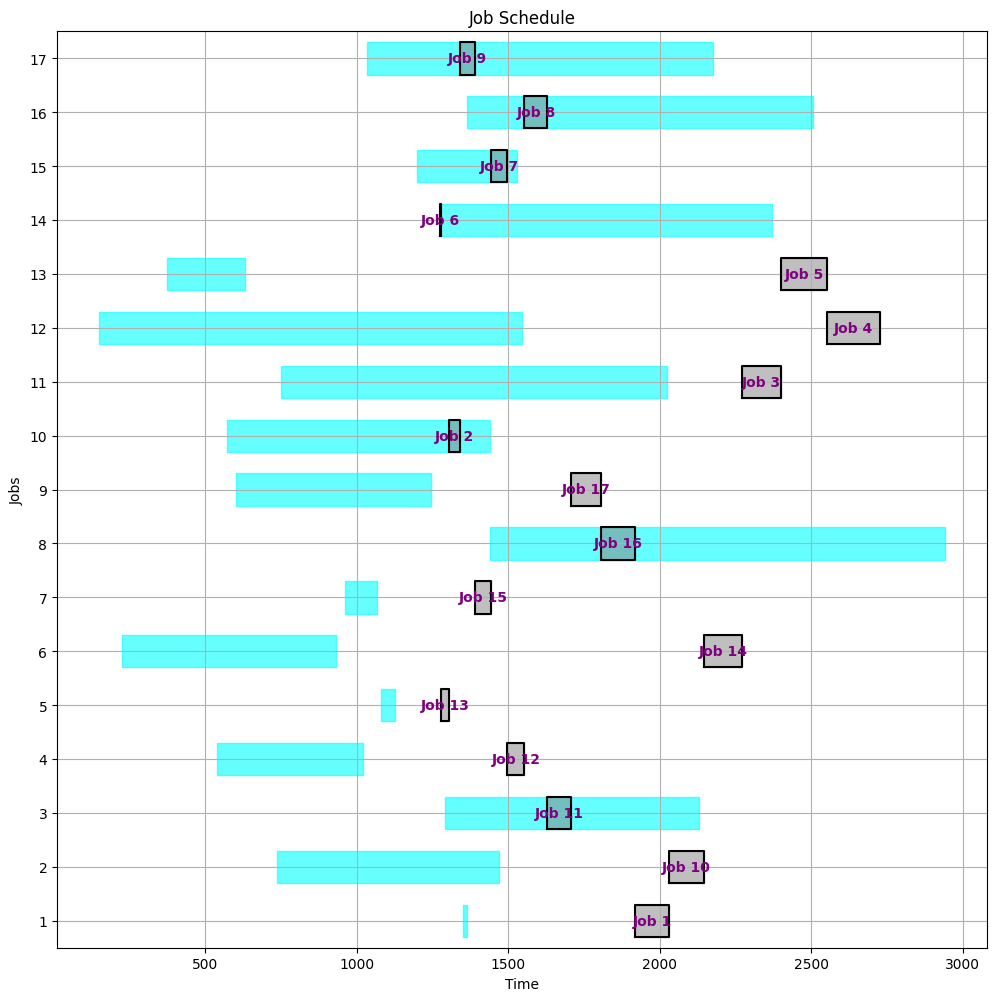

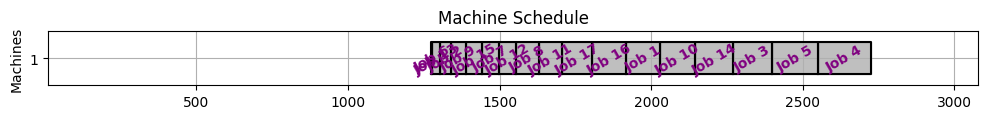

In [25]:
order=sorted(JOBS, key=lambda x: (JOBS[x]['duration'], x))
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))
# SPT 
print("\nEDD Order:")
print_job_order(JOBS, order)
kpi(JOBS, SCHEDULE)

### EDD


EDD Order:


,Job,Start (min),Duration (min),Due (min),Weight
0,5,375,153,630,1
1,14,225,127,930,1
2,12,540,56,1020,1
3,15,960,53,1065,3
4,13,1080,27,1125,1
5,17,600,99,1245,4
6,1,1365,113,1350,1
7,2,570,35,1440,3
8,10,735,114,1470,1
9,7,1200,54,1530,3


{'Makespan': 2815,
 'Max Pastdue': 2002,
 'Sum of Pastdue': 10581,
 'Number Pastdue': 15,
 'Number on Time': 2,
 'Fraction on Time': 0.11764705882352941}

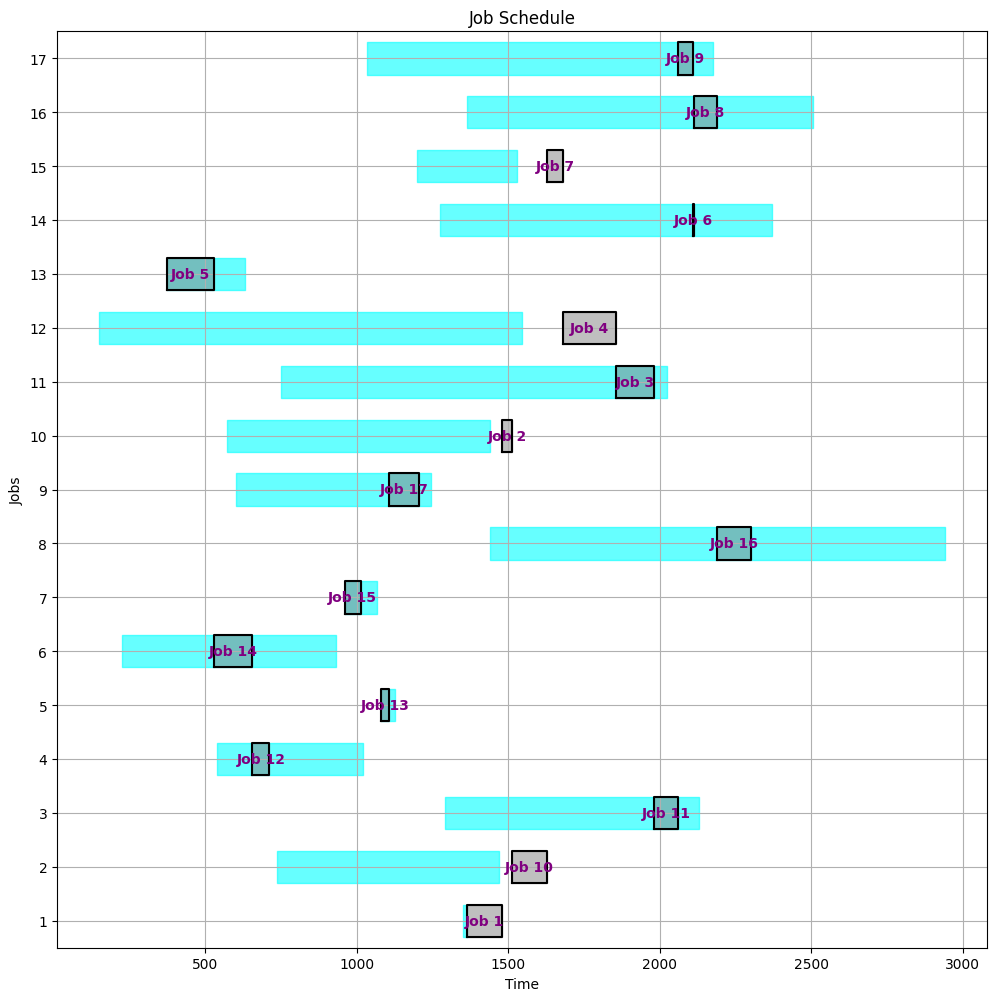

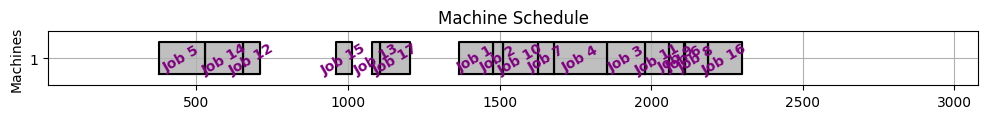

In [26]:
order = sorted(JOBS, key=lambda x: (JOBS[x]['due'], x))
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))
# EDD - Earliest Due Date first
print("\nEDD Order:")
print_job_order(JOBS, order)
kpi(JOBS, SCHEDULE)

## Question 7

Develop a MILP model designed to efficiently minimize the average completion time of
the inspection station.

1.0


{'Makespan': 2890.0,
 'Max Pastdue': 1540.0,
 'Sum of Pastdue': 1540.0,
 'Number Pastdue': 1,
 'Number on Time': 16,
 'Fraction on Time': 0.9411764705882353}

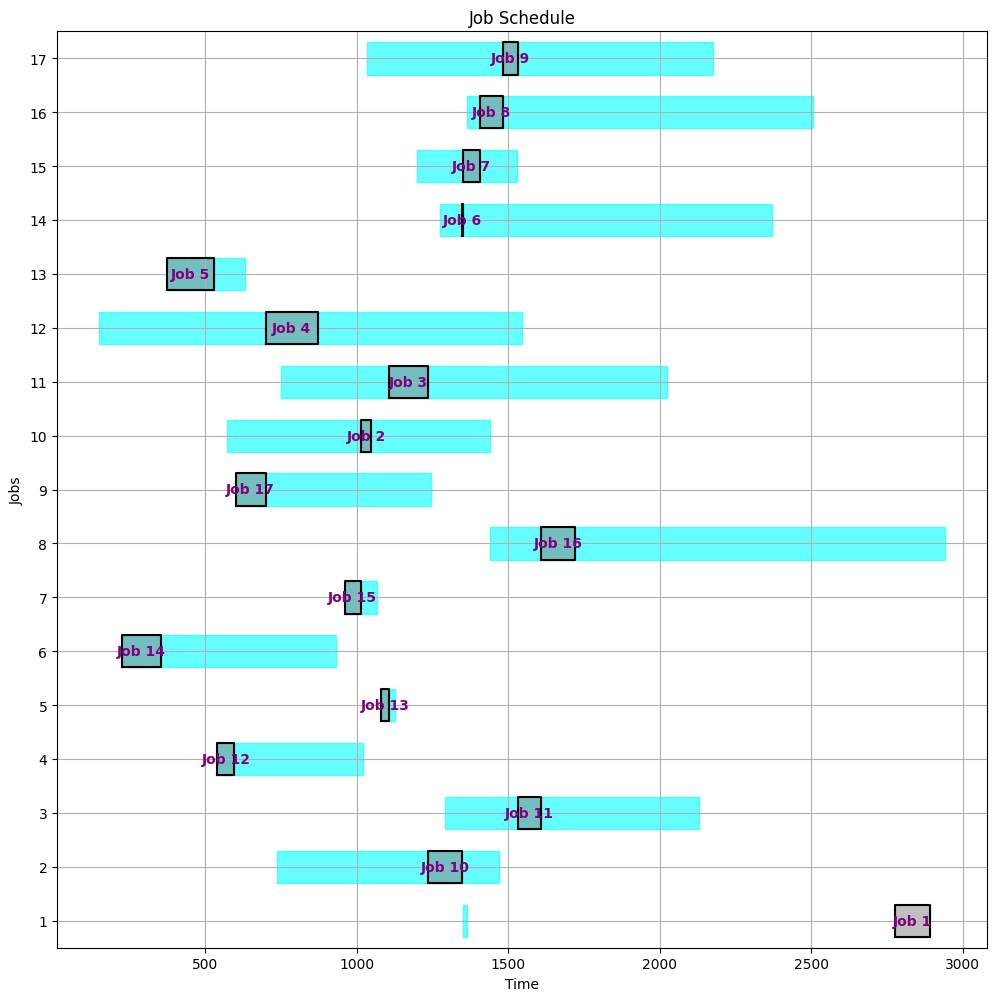

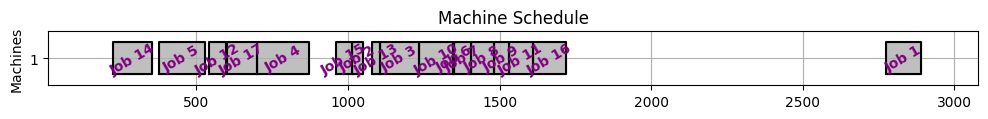

In [53]:
SCHEDULE = opt_schedule(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

<span style="color: orange">
using the milp of lab 4.5 for 1 machine
</span>

## Question 8
Assume that the inspection station is not ready for use for 15 minutes after the first job is
completed for inspection. What would be the optimal results in this scenario? Are they
different from the results achieved earlier? If so, how?

<span style="color: orange">
New Constraint: After each job is completed, the inspection station cannot start the next job for 15 minutes.
</span>

{'Makespan': 2890.0,
 'Max Pastdue': 1540.0,
 'Sum of Pastdue': 1540.0,
 'Number Pastdue': 1,
 'Number on Time': 16,
 'Fraction on Time': 0.9411764705882353}

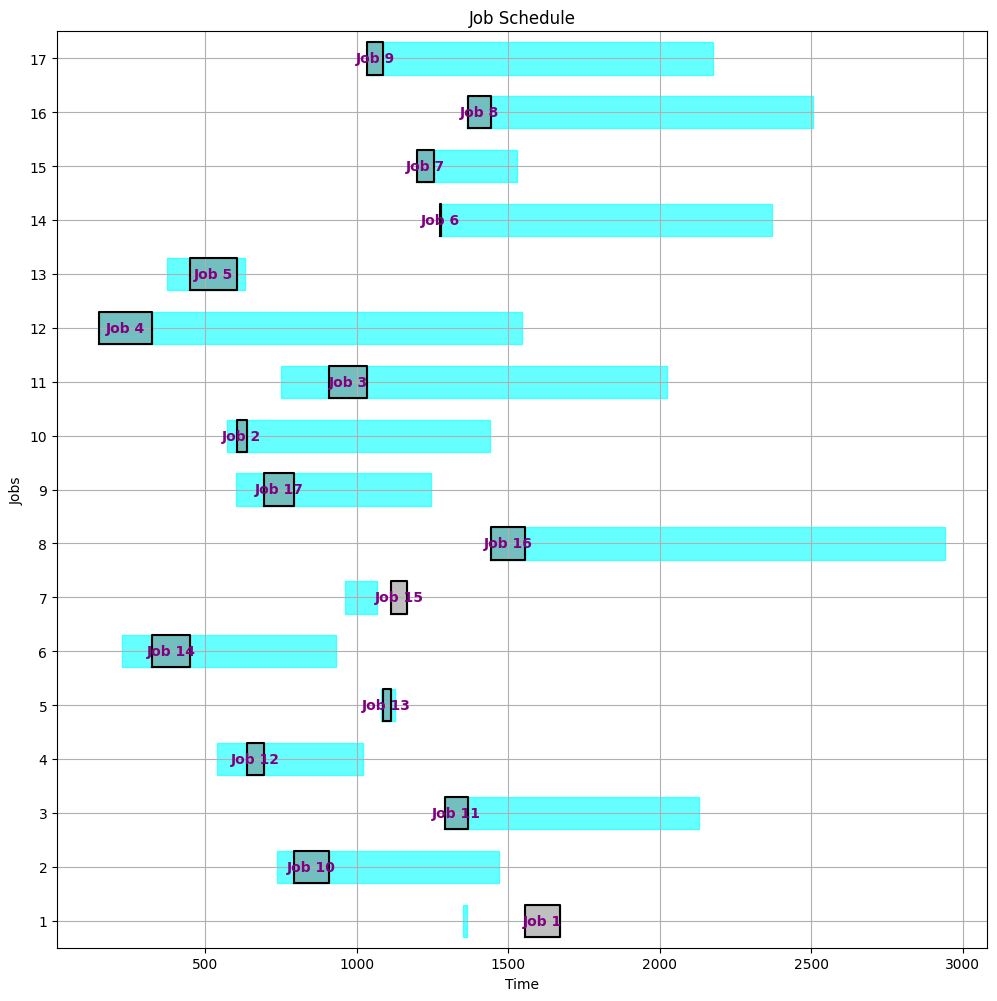

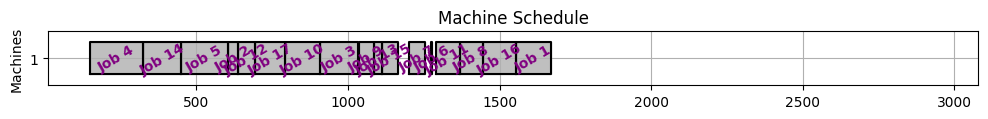

In [40]:
def milp_with_single_delay(JOBS, delay):
    # Create the MIP solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        return

    # Big M value
    BigM = 10000

    # Decision variables
    completion_time = {}
    start_time = {}
    y = {}

    for job in JOBS:
        completion_time[job] = solver.NumVar(0, BigM, f'completion_time_{job}')
        start_time[job] = solver.NumVar(0, BigM, f'start_time_{job}')

    for i in JOBS:
        for j in JOBS:
            if i != j:
                y[(i, j)] = solver.BoolVar(f'y_{i}_{j}')

    # Constraints
    for job in JOBS:
        solver.Add(start_time[job] >= JOBS[job]['release'])
        solver.Add(completion_time[job] == start_time[job] + JOBS[job]['duration'])

    for i in JOBS:
        for j in JOBS:
            if i != j:
                if i == 'first_job':
                    solver.Add(start_time[i] + JOBS[i]['duration'] + delay <= start_time[j] + BigM * (1 - y[(i, j)]))
                else:
                    solver.Add(start_time[i] + JOBS[i]['duration'] <= start_time[j] + BigM * (1 - y[(i, j)]))
                solver.Add(start_time[j] + JOBS[j]['duration'] <= start_time[i] + BigM * y[(i, j)])

    # Objective: Minimize the average completion time
    solver.Minimize(solver.Sum([completion_time[job] for job in JOBS]) / len(JOBS))

    # Solve
    status = solver.Solve()

    # Process solution
    if status == pywraplp.Solver.OPTIMAL:
        SCHEDULE = {}
        for job in JOBS:
            SCHEDULE[job] = {
                'start': start_time[job].solution_value(),
                'finish': completion_time[job].solution_value()
            }
        return SCHEDULE
    else:
        return None

# Mark the first job
first_job = '1'

# Run the model with a 15-minute delay after the first job
DELAY = 15
SCHEDULE_WITH_DELAY = milp_with_single_delay(JOBS, DELAY)
gantt(JOBS, SCHEDULE_WITH_DELAY)
kpi(JOBS, SCHEDULE)

<span style="color: orange">
It puts job 1 at the end, which is logical
</span>

WoodCraft Creations has a line dedicated to home accessories. Among their offerings are
various types of rugs, including standard designs in two variations: black-and-white and colored.
In line with their sustainability program, they’ve introduced a new line featuring natural-fiber
rugs. These rugs are typically produced based on a make-to-stock policy. The specific production stages for each product are outlined in Table 8. The table also provides the corresponding
processing times for each product at each stage.

Table 8: Processing Time of Each Item of Different Types on Different Machines

| Product          | Fiber Processing | Coloring | Weaving | Inspection |
|------------------|------------------|----------|---------|------------|
| Natural-Fiber Rug| 1.0              | 5.0      | 4.0     | 1.5        |
| Black & White Rug| -                | -        | 4.5     | 1.0        |
| Colored Rug      | -                | 3.0      | 5.0     | 1.5        |

WoodCraft Creations produces all the products in batches, and batch plans can operate under
different storage policies. In this particular case, we will consider the following two storage
policies:

- Unlimited Intermediate Storage (UIS): The intermediate product can be stored indefinitely. There is enough storage capacity.


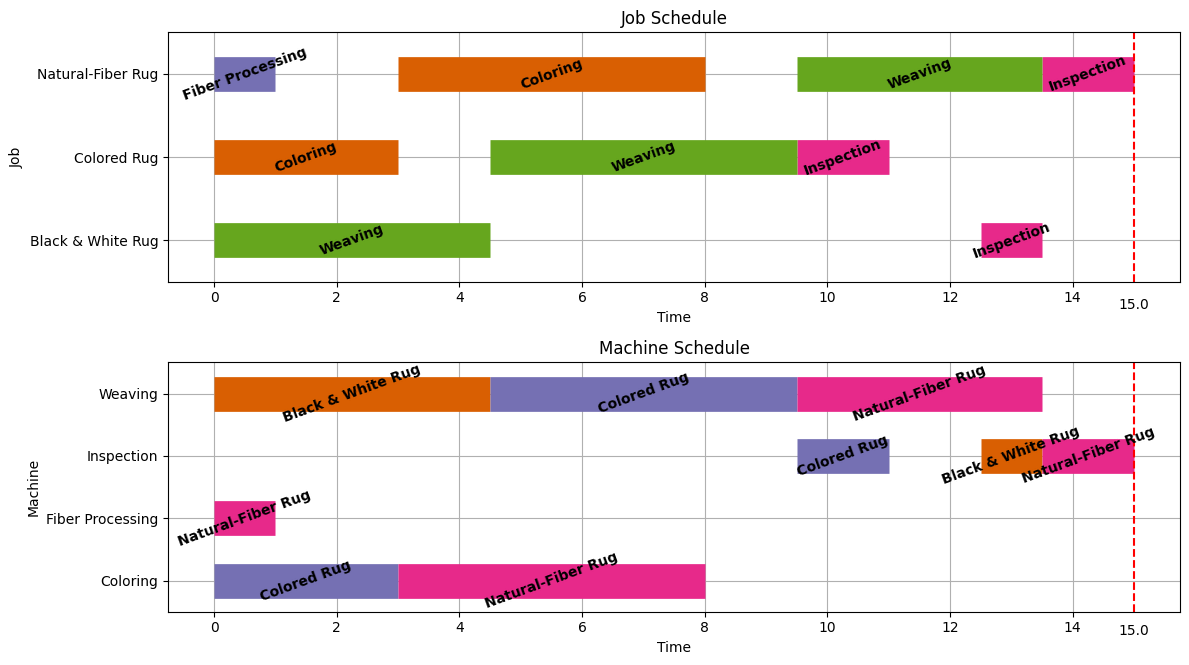

In [71]:
TASKS = {
    ('Natural-Fiber Rug', 'Fiber Processing'): {'dur': 1.0, 'prec': None},
    ('Natural-Fiber Rug', 'Coloring'): {'dur': 5.0, 'prec': ('Natural-Fiber Rug', 'Fiber Processing')},
    ('Natural-Fiber Rug', 'Weaving'): {'dur': 4.0, 'prec': ('Natural-Fiber Rug', 'Coloring')},
    ('Natural-Fiber Rug', 'Inspection'): {'dur': 1.5, 'prec': ('Natural-Fiber Rug', 'Weaving')},
    ('Black & White Rug', 'Weaving'): {'dur': 4.5, 'prec': None},
    ('Black & White Rug', 'Inspection'): {'dur': 1.0, 'prec': ('Black & White Rug', 'Weaving')},
    ('Colored Rug', 'Coloring'): {'dur': 3.0, 'prec': None},
    ('Colored Rug', 'Weaving'): {'dur': 5.0, 'prec': ('Colored Rug', 'Coloring')},
    ('Colored Rug', 'Inspection'): {'dur': 1.5, 'prec': ('Colored Rug', 'Weaving')}
}


TASKS

def visualize(results):

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'black', 'weight':'bold', 'ha':'center', 'va':'center', 'rotation': 20}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)

    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

# visualize(results)

def jobshop_model(TASKS):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Define Sets
    JOBS = [j for (j,m) in TASKS] #check
    MACHINES = [m for (j,m) in TASKS.keys()]

    # establish an upper bound on makespan
    ub = sum(TASKS[t]['dur'] for t in TASKS.keys())

    # decision variables
    start = []
    auxilaryVar = []
    for t in TASKS.keys():
        suffix = '_%s' % str(t)
        start.append(m.NumVar(0, ub, 'start'))

        auxilaryVar_nested = []
        for tp in TASKS.keys():
            suffix = '_%s' % str(t)
            auxilaryVar_nested.append(m.BoolVar('z' ))
        auxilaryVar.append(auxilaryVar_nested)


    # additional decision variables for use in the objecive
    makespan = m.NumVar(0, ub, 'makespan')

    # constraints
    for t,task in enumerate(TASKS.keys()):
        m.Add(start[t] + TASKS[task]['dur'] <= makespan)

        for tp,taskp in enumerate(TASKS.keys()):
            if task == TASKS[taskp]['prec']:
                m.Add(start[t] + TASKS[task]['dur'] <= start[tp])

            if task[1] == taskp[1] and t < tp:  #same machine
                m.Add(start[t] + TASKS[task]['dur'] <= start[tp] + ub * auxilaryVar[t][tp])
                m.Add(start[tp] + TASKS[taskp]['dur'] <= start[t] + ub * (1-auxilaryVar[t][tp]))


    # objective function
    m.Minimize(makespan)
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        results = [{'Job': task[0],
                    'Machine': task[1],
                    'Start': start[t].solution_value(),
                    'Duration': TASKS[task]['dur'],
                    'Finish': start[t].solution_value() + TASKS[task]['dur']}
                     for t,task in enumerate(TASKS.keys())]

        results = []
        for t,task in enumerate(TASKS.keys()):
            results.append({'Job': task[0],
                    'Machine': task[1],
                    'Start': start[t].solution_value(),
                    'Duration': TASKS[task]['dur'],
                    'Finish': start[t].solution_value() + TASKS[task]['dur']})
        return results

    else:
        print('The problem does not have an optimal solution.')


results = jobshop_model(TASKS)
visualize(results)

- Zero-Wait (ZW): The material cannot wait between different processes and must be processed as soon as it is produced.

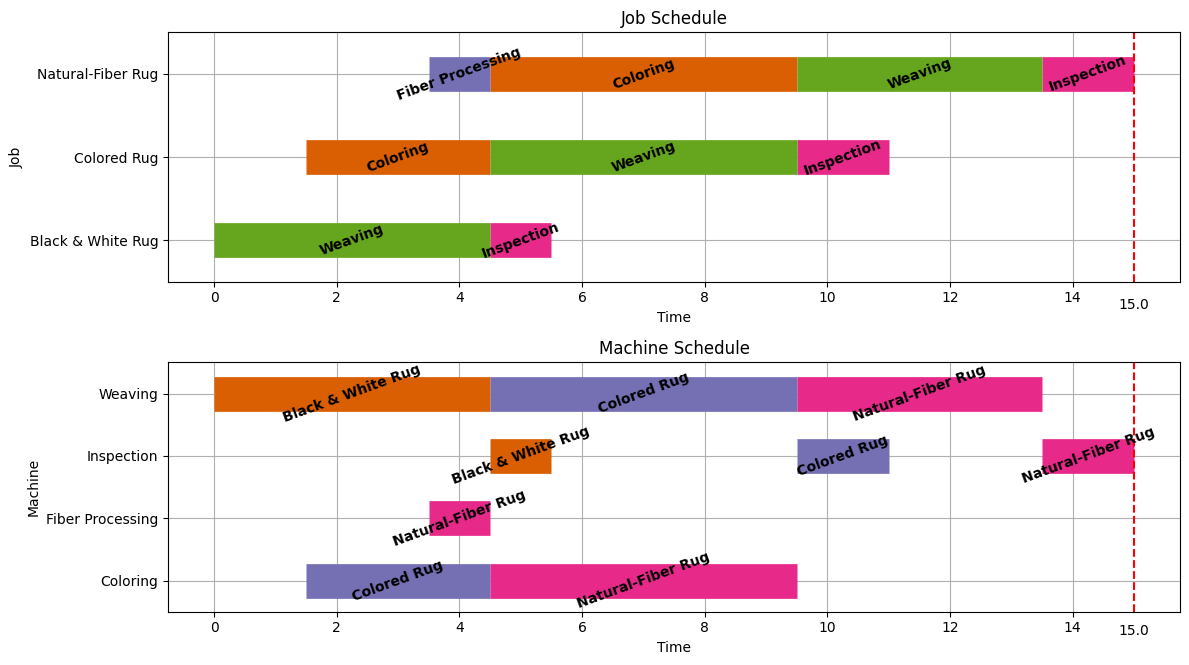

In [72]:
def jobshop_model_zero_wait(TASKS):
    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')
    if not m:
        return

    # Define Sets
    JOBS = list(set(j for (j, _) in TASKS))
    MACHINES = list(set(m for (_, m) in TASKS.keys()))

    # Establish an upper bound on makespan
    ub = sum(TASKS[t]['dur'] for t in TASKS.keys())

    # Decision variables
    start = {}
    auxilaryVar = {}
    for t in TASKS.keys():
        start[t] = m.NumVar(0, ub, f'start_{t}')
        for tp in TASKS.keys():
            if t != tp:
                auxilaryVar[(t, tp)] = m.BoolVar(f'aux_{t}_{tp}')

    # Additional decision variables for use in the objective
    makespan = m.NumVar(0, ub, 'makespan')

    # Constraints
    for t in TASKS.keys():
        m.Add(start[t] + TASKS[t]['dur'] <= makespan)

        if TASKS[t]['prec'] is not None:
            # Zero-wait constraint: start the next task immediately after the previous task ends
            m.Add(start[t] == start[TASKS[t]['prec']] + TASKS[TASKS[t]['prec']]['dur'])

    for t, tp in auxilaryVar.keys():
        if t[1] == tp[1]:  # same machine
            m.Add(start[t] + TASKS[t]['dur'] <= start[tp] + ub * auxilaryVar[(t, tp)])
            m.Add(start[tp] + TASKS[tp]['dur'] <= start[t] + ub * (1 - auxilaryVar[(t, tp)]))

    # Objective function
    m.Minimize(makespan)
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        results = [{'Job': t[0],
                    'Machine': t[1],
                    'Start': start[t].solution_value(),
                    'Duration': TASKS[t]['dur'],
                    'Finish': start[t].solution_value() + TASKS[t]['dur']}
                   for t in TASKS.keys()]
        return results
    else:
        print('The problem does not have an optimal solution.')
        return None

# Define tasks
TASKS = {
    ('Natural-Fiber Rug', 'Fiber Processing'): {'dur': 1.0, 'prec': None},
    ('Natural-Fiber Rug', 'Coloring'): {'dur': 5.0, 'prec': ('Natural-Fiber Rug', 'Fiber Processing')},
    ('Natural-Fiber Rug', 'Weaving'): {'dur': 4.0, 'prec': ('Natural-Fiber Rug', 'Coloring')},
    ('Natural-Fiber Rug', 'Inspection'): {'dur': 1.5, 'prec': ('Natural-Fiber Rug', 'Weaving')},
    ('Black & White Rug', 'Weaving'): {'dur': 4.5, 'prec': None},
    ('Black & White Rug', 'Inspection'): {'dur': 1.0, 'prec': ('Black & White Rug', 'Weaving')},
    ('Colored Rug', 'Coloring'): {'dur': 3.0, 'prec': None},
    ('Colored Rug', 'Weaving'): {'dur': 5.0, 'prec': ('Colored Rug', 'Coloring')},
    ('Colored Rug', 'Inspection'): {'dur': 1.5, 'prec': ('Colored Rug', 'Weaving')}
}

# Run the model with zero-wait constraint
results = jobshop_model_zero_wait(TASKS)
visualize(results)


## Question 9
Consider that WoodCraft Creations needs to deliver a batch of ”NNBBCC” rugs (two
batches of natural-fiber rug, two batches of black&white rug and two batches of colored
rug ) to the retail store. What would be the earliest time to deliver this order from the
starting time?

The earliest time to deliver the 'NNBBCC' order is: 28.0 hours from the starting time.


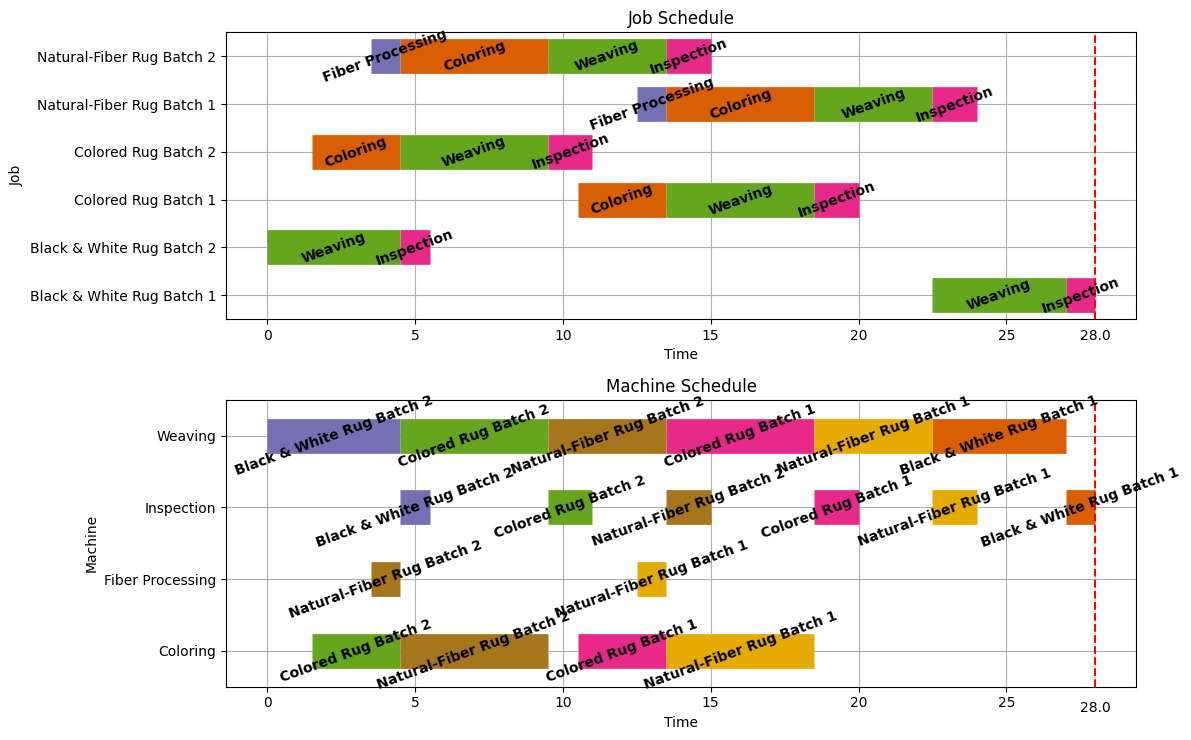

In [73]:
TASKS = {
    # Natural-Fiber Rug Batches
    ('Natural-Fiber Rug Batch 1', 'Fiber Processing'): {'dur': 1.0, 'prec': None},
    ('Natural-Fiber Rug Batch 1', 'Coloring'): {'dur': 5.0, 'prec': ('Natural-Fiber Rug Batch 1', 'Fiber Processing')},
    ('Natural-Fiber Rug Batch 1', 'Weaving'): {'dur': 4.0, 'prec': ('Natural-Fiber Rug Batch 1', 'Coloring')},
    ('Natural-Fiber Rug Batch 1', 'Inspection'): {'dur': 1.5, 'prec': ('Natural-Fiber Rug Batch 1', 'Weaving')},
    ('Natural-Fiber Rug Batch 2', 'Fiber Processing'): {'dur': 1.0, 'prec': None},
    ('Natural-Fiber Rug Batch 2', 'Coloring'): {'dur': 5.0, 'prec': ('Natural-Fiber Rug Batch 2', 'Fiber Processing')},
    ('Natural-Fiber Rug Batch 2', 'Weaving'): {'dur': 4.0, 'prec': ('Natural-Fiber Rug Batch 2', 'Coloring')},
    ('Natural-Fiber Rug Batch 2', 'Inspection'): {'dur': 1.5, 'prec': ('Natural-Fiber Rug Batch 2', 'Weaving')},
    # Black & White Rug Batches
    ('Black & White Rug Batch 1', 'Weaving'): {'dur': 4.5, 'prec': None},
    ('Black & White Rug Batch 1', 'Inspection'): {'dur': 1.0, 'prec': ('Black & White Rug Batch 1', 'Weaving')},
    ('Black & White Rug Batch 2', 'Weaving'): {'dur': 4.5, 'prec': None},
    ('Black & White Rug Batch 2', 'Inspection'): {'dur': 1.0, 'prec': ('Black & White Rug Batch 2', 'Weaving')},
    # Colored Rug Batches
    ('Colored Rug Batch 1', 'Coloring'): {'dur': 3.0, 'prec': None},
    ('Colored Rug Batch 1', 'Weaving'): {'dur': 5.0, 'prec': ('Colored Rug Batch 1', 'Coloring')},
    ('Colored Rug Batch 1', 'Inspection'): {'dur': 1.5, 'prec': ('Colored Rug Batch 1', 'Weaving')},
    ('Colored Rug Batch 2', 'Coloring'): {'dur': 3.0, 'prec': None},
    ('Colored Rug Batch 2', 'Weaving'): {'dur': 5.0, 'prec': ('Colored Rug Batch 2', 'Coloring')},
    ('Colored Rug Batch 2', 'Inspection'): {'dur': 1.5, 'prec': ('Colored Rug Batch 2', 'Weaving')},
}

results = jobshop_model_zero_wait(TASKS)
visualize(results)

# Find the makespan
makespan = max(result['Finish'] for result in results)
print(f"The earliest time to deliver the 'NNBBCC' order is: {makespan} hours from the starting time.")

If you consider the use of the ’UIS policy’, what is the final schedule after
applying this policy ? How this schedule will differ from the simple summation of the
processing times?

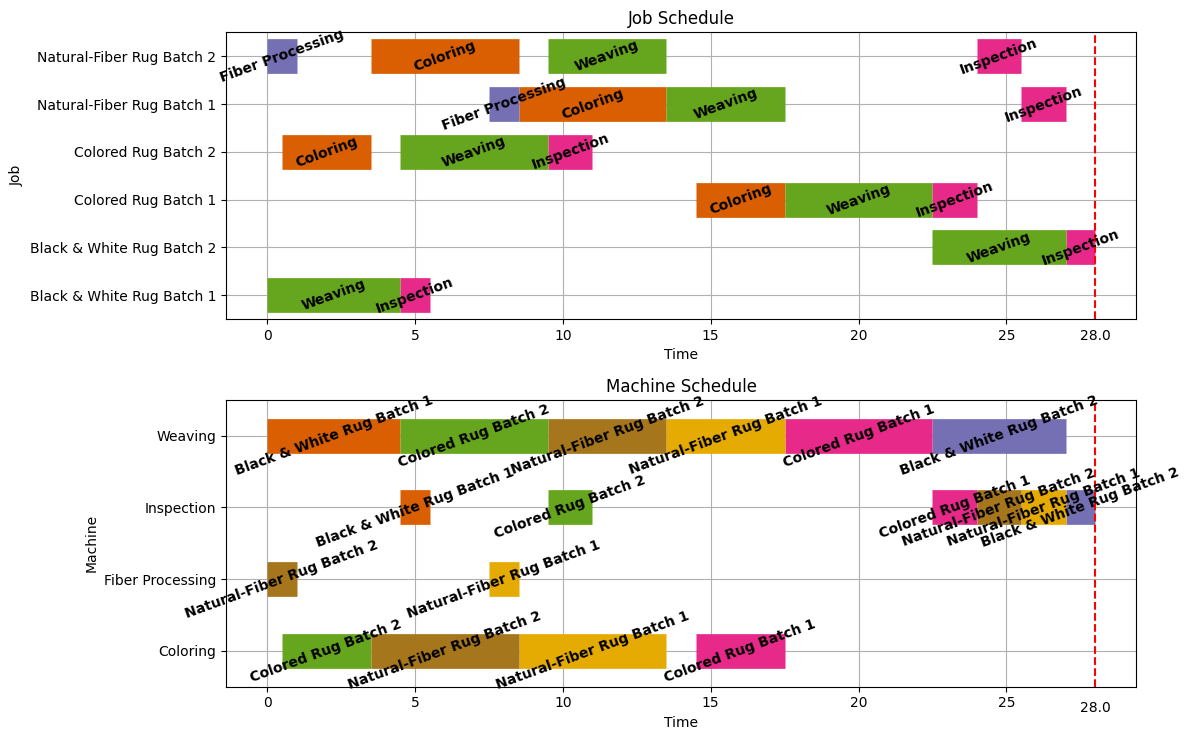

In [74]:
results = jobshop_model(TASKS)
visualize(results)

<span style="color: orange">
same makespan
</span>

## Question 10
Can you use the production planning model to answer the above question? If yes, give
the answer with it. Justify your answers.

<span style="color: orange">
theorique je te la laisse
</span>

## Question 11
Starting from the model in question 9, consider now that the fiber processing section is
only available five time units after the process starts. How does it affect the result, and
why?

The makespan with fiber processing delay is: 27.999999999999996 hours.


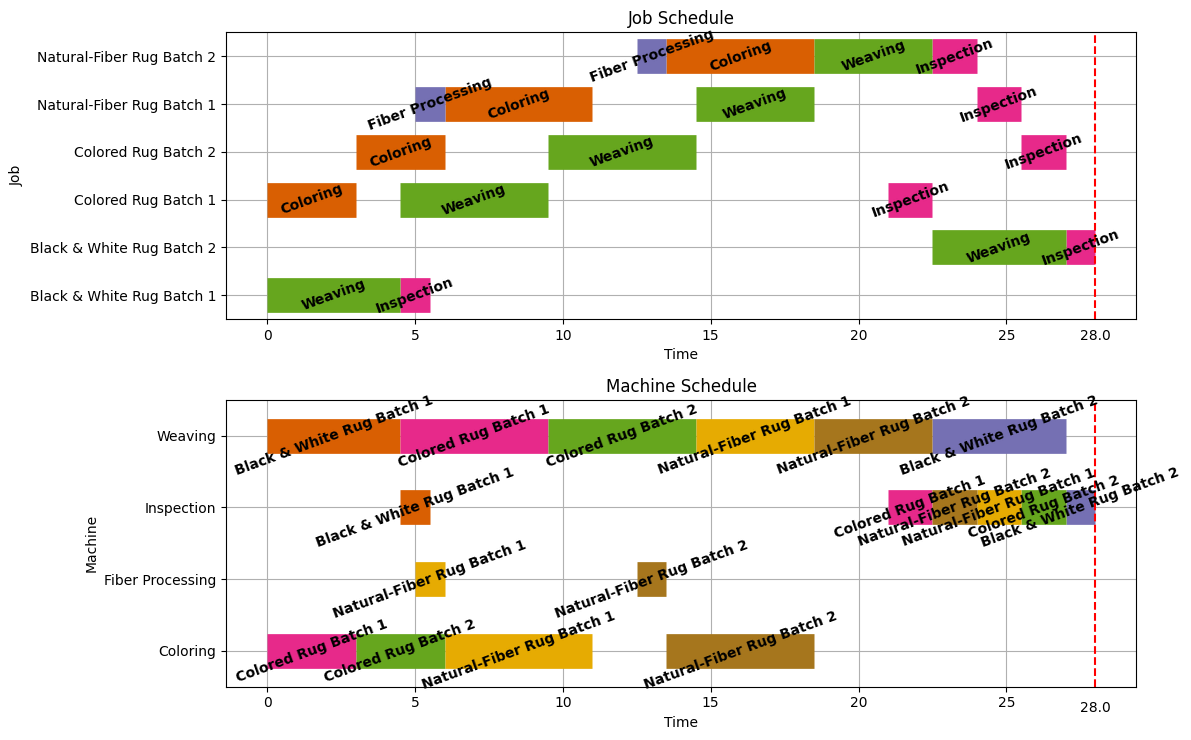

In [75]:
def jobshop_model_with_fiber_delay(TASKS, fiber_delay):
    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')
    if not m:
        return

    # Define Sets
    JOBS = list(set(j for (j, _) in TASKS))
    MACHINES = list(set(m for (_, m) in TASKS.keys()))

    # Establish an upper bound on makespan
    ub = sum(TASKS[t]['dur'] for t in TASKS.keys())

    # Decision variables
    start = {}
    auxilaryVar = {}
    for t in TASKS.keys():
        start[t] = m.NumVar(0, ub, f'start_{t}')
        for tp in TASKS.keys():
            if t != tp:
                auxilaryVar[(t, tp)] = m.BoolVar(f'aux_{t}_{tp}')

    # Additional decision variables for use in the objective
    makespan = m.NumVar(0, ub, 'makespan')

    # Constraints
    for t in TASKS.keys():
        m.Add(start[t] + TASKS[t]['dur'] <= makespan)

        if TASKS[t]['prec'] is not None:
            # Ensure the task starts after its predecessor ends
            m.Add(start[t] >= start[TASKS[t]['prec']] + TASKS[TASKS[t]['prec']]['dur'])

    for t, tp in auxilaryVar.keys():
        if t[1] == tp[1]:  # same machine
            m.Add(start[t] + TASKS[t]['dur'] <= start[tp] + ub * auxilaryVar[(t, tp)])
            m.Add(start[tp] + TASKS[tp]['dur'] <= start[t] + ub * (1 - auxilaryVar[(t, tp)]))

    # Add fiber processing delay constraint
    for t in TASKS.keys():
        if t[1] == 'Fiber Processing':
            m.Add(start[t] >= fiber_delay)

    # Objective function
    m.Minimize(makespan)
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        results = [{'Job': t[0],
                    'Machine': t[1],
                    'Start': start[t].solution_value(),
                    'Duration': TASKS[t]['dur'],
                    'Finish': start[t].solution_value() + TASKS[t]['dur']}
                   for t in TASKS.keys()]
        return results
    else:
        print('The problem does not have an optimal solution.')
        return None

# Run the model with fiber processing delay
fiber_delay = 5  # Fiber processing section is available 5 time units after the process starts
results_fiber_delay = jobshop_model_with_fiber_delay(TASKS, fiber_delay)
visualize(results_fiber_delay)

# Find the makespan
makespan_fiber_delay = max(result['Finish'] for result in results_fiber_delay)
print(f"The makespan with fiber processing delay is: {makespan_fiber_delay} hours.")


<span style="color: orange">
using the same NNBBCC model we see that it does not change anything
</span>

## Question 12
In the stations, to consider specific protocols, they need to clean each section after producing one batch. So if natural-fiber rug is in the inspection station, they must do some
cleaning, unless the next batch is again natural-fiber rug. Consider a cleaning time of one
unit. Add this constraint to your model and report the result. Describe how it affects your
previous solution and what the differences are.

The makespan with cleaning time constraint is: 30.499999999999996 hours.


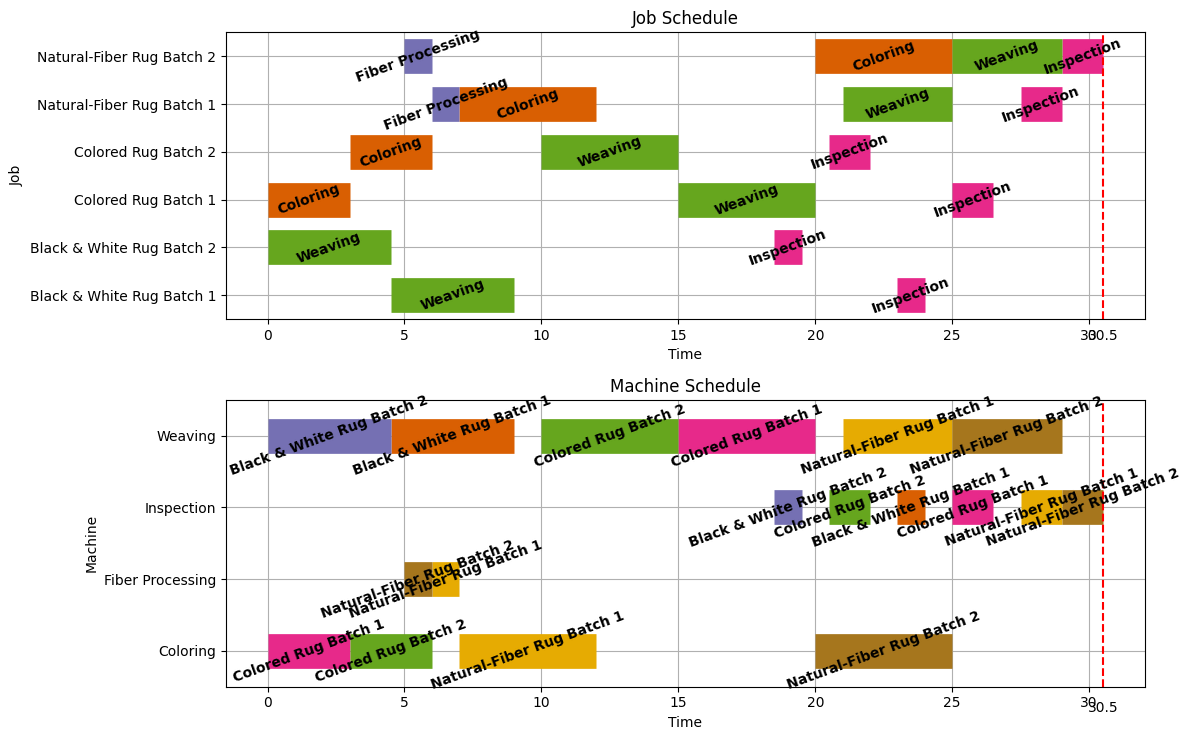

In [76]:
CLEANING_TIME = 1.0  # Time unit for cleaning between different rug types
def jobshop_model_with_cleaning(TASKS, fiber_delay, cleaning_time):
    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')
    if not m:
        return

    # Define Sets
    JOBS = list(set(j for (j, _) in TASKS))
    MACHINES = list(set(m for (_, m) in TASKS.keys()))

    # Establish an upper bound on makespan
    ub = sum(TASKS[t]['dur'] for t in TASKS.keys()) + cleaning_time * (len(TASKS) - 1)

    # Decision variables
    start = {}
    auxilaryVar = {}
    for t in TASKS.keys():
        start[t] = m.NumVar(0, ub, f'start_{t}')
        for tp in TASKS.keys():
            if t != tp:
                auxilaryVar[(t, tp)] = m.BoolVar(f'aux_{t}_{tp}')

    # Additional decision variables for use in the objective
    makespan = m.NumVar(0, ub, 'makespan')

    # Constraints
    for t in TASKS.keys():
        m.Add(start[t] + TASKS[t]['dur'] <= makespan)

        if TASKS[t]['prec'] is not None:
            # Ensure the task starts after its predecessor ends
            m.Add(start[t] >= start[TASKS[t]['prec']] + TASKS[TASKS[t]['prec']]['dur'])

    for t, tp in auxilaryVar.keys():
        if t[1] == tp[1]:  # same machine
            if t[0].split()[0] != tp[0].split()[0]:  # Different rug types require cleaning
                m.Add(start[t] + TASKS[t]['dur'] + cleaning_time <= start[tp] + ub * auxilaryVar[(t, tp)])
            else:
                m.Add(start[t] + TASKS[t]['dur'] <= start[tp] + ub * auxilaryVar[(t, tp)])
            m.Add(start[tp] + TASKS[tp]['dur'] <= start[t] + ub * (1 - auxilaryVar[(t, tp)]))

    # Add fiber processing delay constraint
    for t in TASKS.keys():
        if t[1] == 'Fiber Processing':
            m.Add(start[t] >= fiber_delay)

    # Objective function
    m.Minimize(makespan)
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        results = [{'Job': t[0],
                    'Machine': t[1],
                    'Start': start[t].solution_value(),
                    'Duration': TASKS[t]['dur'],
                    'Finish': start[t].solution_value() + TASKS[t]['dur']}
                   for t in TASKS.keys()]
        return results
    else:
        print('The problem does not have an optimal solution.')
        return None

# Run the model with cleaning time constraint
fiber_delay = 5  # Fiber processing section is available 5 time units after the process starts
cleaning_time = 1.0  # Time unit for cleaning between different rug types
results_with_cleaning = jobshop_model_with_cleaning(TASKS, fiber_delay, cleaning_time)
visualize(results_with_cleaning)

# Find the makespan
makespan_with_cleaning = max(result['Finish'] for result in results_with_cleaning)
print(f"The makespan with cleaning time constraint is: {makespan_with_cleaning} hours.")


In [77]:
# Calculate the difference
difference_cleaning = makespan_with_cleaning - makespan_fiber_delay
print(f"Difference between fiber delay makespan and makespan with cleaning time constraint: {difference_cleaning} hours.")


Difference between fiber delay makespan and makespan with cleaning time constraint: 2.5 hours.


## Question 13
Assume a Zero-wait policy that prevents the material from waiting between different processes. Add the corresponding constraint to your model and comment on the result.

The makespan with zero-wait, cleaning time, and fiber processing delay is: 31.5 hours.


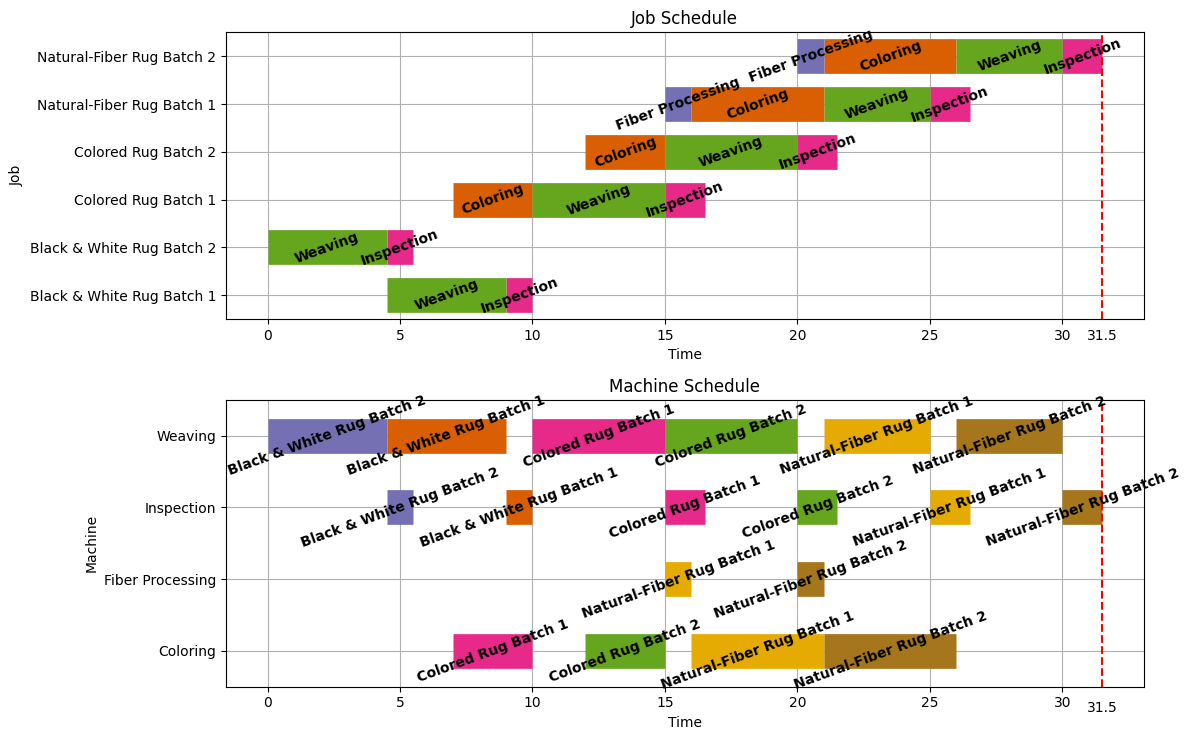

In [78]:
def jobshop_model_with_cleaning_and_zero_wait(TASKS, fiber_delay, cleaning_time):
    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')
    if not m:
        return

    # Define Sets
    JOBS = list(set(j for (j, _) in TASKS))
    MACHINES = list(set(m for (_, m) in TASKS.keys()))

    # Establish an upper bound on makespan
    ub = sum(TASKS[t]['dur'] for t in TASKS.keys()) + cleaning_time * (len(TASKS) - 1)

    # Decision variables
    start = {}
    auxilaryVar = {}
    for t in TASKS.keys():
        start[t] = m.NumVar(0, ub, f'start_{t}')
        for tp in TASKS.keys():
            if t != tp:
                auxilaryVar[(t, tp)] = m.BoolVar(f'aux_{t}_{tp}')

    # Additional decision variables for use in the objective
    makespan = m.NumVar(0, ub, 'makespan')

    # Constraints
    for t in TASKS.keys():
        m.Add(start[t] + TASKS[t]['dur'] <= makespan)

        if TASKS[t]['prec'] is not None:
            # Zero-wait constraint: Ensure the next task starts immediately after the current task ends
            m.Add(start[t] == start[TASKS[t]['prec']] + TASKS[TASKS[t]['prec']]['dur'])

    for t, tp in auxilaryVar.keys():
        if t[1] == tp[1]:  # same machine
            if t[0].split()[0] != tp[0].split()[0]:  # Different rug types require cleaning
                m.Add(start[t] + TASKS[t]['dur'] + cleaning_time <= start[tp] + ub * auxilaryVar[(t, tp)])
            else:
                m.Add(start[t] + TASKS[t]['dur'] <= start[tp] + ub * auxilaryVar[(t, tp)])
            m.Add(start[tp] + TASKS[tp]['dur'] <= start[t] + ub * (1 - auxilaryVar[(t, tp)]))

    # Add fiber processing delay constraint
    for t in TASKS.keys():
        if t[1] == 'Fiber Processing':
            m.Add(start[t] >= fiber_delay)

    # Objective function
    m.Minimize(makespan)
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        results = [{'Job': t[0],
                    'Machine': t[1],
                    'Start': start[t].solution_value(),
                    'Duration': TASKS[t]['dur'],
                    'Finish': start[t].solution_value() + TASKS[t]['dur']}
                   for t in TASKS.keys()]
        return results
    else:
        print('The problem does not have an optimal solution.')
        return None

# Run the model with zero-wait, fiber delay, and cleaning time constraint
fiber_delay = 5  # Fiber processing section is available 5 time units after the process starts
cleaning_time = 1.0  # Time unit for cleaning between different rug types
results_with_cleaning_and_zero_wait = jobshop_model_with_cleaning_and_zero_wait(TASKS, fiber_delay, cleaning_time)
visualize(results_with_cleaning_and_zero_wait)

# Find the makespan
makespan_with_cleaning_and_zero_wait = max(result['Finish'] for result in results_with_cleaning_and_zero_wait)
print(f"The makespan with zero-wait, cleaning time, and fiber processing delay is: {makespan_with_cleaning_and_zero_wait} hours.")
